### 0.1 Load base model - note

Since I performed outlier removal on the entire dataset, with your permission, I'm not loading the base model from the previous notebook but will later (on clause 2.5.2) train a new one with the same basic pipeline. The reason for that is that when I later remove outliers, I change the overall dataset distribution, that in turn effects the train, validation and test sets. If we wish the comparison to be fair, we have to compare these on the same test set, and we want to make sure that test set is a good representative of the data (that's why I did not use the intersection of the old and new test sets as my test set).

### 0.2 Utilities

In [234]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import optuna
import random
import warnings
from xgboost import XGBRegressor
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import pearsonr
from typing import Optional
from sklearn.base import BaseEstimator, TransformerMixin
import smogn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import chi2
from sklearn.compose import TransformedTargetRegressor
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [241]:
# Utility constants
predictor_features = [
    'weight', 'length', 'width', 'depth', 'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
    'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR', 'shape_PRINCESS', 'shape_ROUND', 'encoded_clarity',
    'encoded_color', 'encoded_cut', 'encoded_polish', 'encoded_symmetry', 'encoded_fluorescence'
]

all_features =  [
        'weight', 'price', 'length', 'width', 'depth',
        'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
        'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR',
        'shape_PRINCESS', 'shape_ROUND', 'encoded_clarity',
        'encoded_color', 'encoded_cut', 'encoded_polish',
        'encoded_symmetry', 'encoded_fluorescence'
    ]


# Utility functions        
def handle_outliers(df, cols, method='iqr', threshold=1.5, clamp=False):
    """
    Handles outliers in a DataFrame based on specified numerical columns and method.
    It can either remove or clamp outliers.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cols (list of str): List of column names to check for outliers.
    - method (str): Method to use for outlier detection ('iqr' or 'zscore'). Default is 'iqr'.
    - threshold (float): The threshold multiplier. Default is 1.5 for IQR and 3 for z-score.
    - clamp (bool): If True, clamping will replace outliers with boundary values. Default is False (removes outliers).

    Returns:
    - pd.DataFrame: DataFrame with outliers handled (removed or clamped).
    """
    df_handled = df.copy()
    print(f"The shape before handling outliers is: {df_handled.shape}")
    
    if method == 'iqr':
        for col in cols:
            if pd.api.types.is_numeric_dtype(df_handled[col]):
                Q1 = df_handled[col].quantile(0.25)
                Q3 = df_handled[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                before = df_handled.shape[0]
                
                if clamp:
                    df_handled[col] = df_handled[col].clip(lower=lower_bound, upper=upper_bound)
                else:
                    df_handled = df_handled[(df_handled[col] >= lower_bound) & (df_handled[col] <= upper_bound)]
                
                after = df_handled.shape[0]
                if clamp:
                    print(f"Clamped outliers in '{col}' using IQR method.")
                else:
                    print(f"Removed {before - after} outliers from '{col}' using IQR method.")
            else:
                print(f"Column '{col}' is not numerical and was skipped.")
        print(f"The shape after handling outliers is: {df_handled.shape}")
                
    elif method == 'zscore':
        from scipy import stats
        for col in cols:
            if pd.api.types.is_numeric_dtype(df_handled[col]):
                z_scores = np.abs(stats.zscore(df_handled[col].dropna()))
                before = df_handled.shape[0]
                
                if clamp:
                    df_handled[col] = df_handled[col].where(z_scores < threshold, df_handled[col].clip(lower=-threshold, upper=threshold))
                else:
                    df_handled = df_handled.loc[z_scores < threshold]
                
                after = df_handled.shape[0]
                if clamp:
                    print(f"Clamped outliers in '{col}' using Z-Score method.")
                else:
                    print(f"Removed {before - after} outliers from '{col}' using Z-Score method.")
            else:
                print(f"Column '{col}' is not numerical and was skipped.")
        print(f"The shape after handling outliers is: {df_handled.shape}")
                
    else:
        raise ValueError("Method must be either 'iqr' or 'zscore'")
    
    return df_handled


def train_xgb_with_validation_save_model(train_data: pd.DataFrame, 
                                           val_data: pd.DataFrame, 
                                           target_column: str, 
                                           model_filename: str):
    """
    Trains an XGBoost regression model on the training data, evaluates its performance on the validation data,
    and saves the trained model to a file using pickle.

    Parameters:
        train_data (pd.DataFrame): The training data containing features and the target.
        val_data (pd.DataFrame): The validation data used to evaluate the model.
        target_column (str): The name of the target variable column.
        model_filename (str): The filename (and path) where the model will be saved.

    Returns:
        model: The trained XGBoost model.
    """
    # Prepare the training and validation datasets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]

    # Initialize the XGBoost regressor with default parameters
    model = xgb.XGBRegressor(random_state=42, early_stopping_rounds=3)
    
    # Train the model with early stopping on the validation set
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )
    
    # Evaluate model performance on both datasets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    print(f"Validation RMSE: {val_rmse:.4f}")
    
    # Save the trained model to disk using pickle
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_filename}")
    
    return model


def load_xgb_model(model_path: str):
    with open(model_path, 'rb') as f:
        return pickle.load(f)
    
    
def visualize_model_bias_trends(model_path, test_df, target_feature):
    """
    Visualizes biases and trends for a regression model using a test DataFrame.
    
    Parameters:
        model_path (str): Path to the pickle file containing the trained regression model.
        test_df (pd.DataFrame): DataFrame containing the test dataset (features and target).
        target_feature (str): Name of the target variable column in the dataset.
    """
    # 1. Load the regression model from a pickle file
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # 2. Ensure the target feature exists in the DataFrame
    if target_feature not in test_df.columns:
        raise ValueError(f"Target feature '{target_feature}' not found in the dataset.")
    
    # 3. Separate features and target
    X = test_df.drop(columns=[target_feature])
    y = test_df[target_feature]
    
    # 4. Generate predictions and compute residuals
    preds = model.predict(X)
    residuals = preds - y  # Positive: overestimate, Negative: underestimate
    
    # Compute summary statistics for the residuals
    mean_resid = np.mean(residuals)
    median_resid = np.median(residuals)
    std_resid = np.std(residuals)
    
    print("=== Model Bias Analysis ===")
    print(f"Mean Residual: {mean_resid:.4f}  --> Model is {'overestimating' if mean_resid > 0 else 'underestimating' if mean_resid < 0 else 'well-calibrated'} on average.")
    print(f"Median Residual: {median_resid:.4f}")
    print(f"Standard Deviation of Residuals: {std_resid:.4f}\n")
    
    # 4. Visualizations
    
    # a) Predicted vs. True Values
    plt.figure(figsize=(8, 6))
    plt.scatter(y, preds, alpha=0.6, edgecolor='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    title = "Predicted vs. True Values\n"
    if mean_resid > 0:
        title += "Model tends to overestimate on average"
    elif mean_resid < 0:
        title += "Model tends to underestimate on average"
    else:
        title += "No systematic bias detected"
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # b) Residual Distribution (Histogram with KDE)
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.axvline(0, color='red', linestyle='--', label="Zero Error")
    plt.xlabel("Residual (Prediction - True)")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # c) Residuals vs. True Values
    plt.figure(figsize=(8, 6))
    plt.scatter(y, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. True Values")
    plt.tight_layout()
    plt.show()
    
    # d) Correlation between Absolute Error and Numeric Features
    abs_errors = np.abs(residuals)
    numeric_features = X.select_dtypes(include=[np.number])
    if not numeric_features.empty:
        correlations = {}
        for col in numeric_features.columns:
            correlations[col] = np.corrcoef(numeric_features[col], abs_errors)[0, 1]
        # Sort features by the absolute correlation value
        corr_series = pd.Series(correlations).sort_values(key=lambda x: np.abs(x), ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=corr_series.index, y=corr_series.values, palette="coolwarm")
        plt.xlabel("Numeric Features")
        plt.ylabel("Correlation with Absolute Error")
        plt.title("Correlation between Numeric Features and Absolute Error")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric features available for correlation with errors.")
    
    # e) Average Residual by Deciles of True Values
    df_temp = pd.DataFrame({'true': y, 'residual': residuals})
    df_temp['decile'] = pd.qcut(df_temp['true'], 10, duplicates='drop')
    decile_means = df_temp.groupby('decile')['residual'].mean()
    
    plt.figure(figsize=(10, 6))
    decile_means.plot(kind='bar', color='mediumpurple')
    plt.xlabel("Deciles of True Values")
    plt.ylabel("Mean Residual")
    plt.title("Mean Residual by Deciles of True Values")
    plt.tight_layout()
    plt.show()


def hyperparameter_tuning_pipeline(train_data_path, validation_data_path, target_column_name='price'):
    # List of columns to select
    columns_to_select = [
        'weight', 'price', 'length', 'width', 'depth',
        'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
        'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR',
        'shape_PRINCESS', 'shape_ROUND', 'encoded_clarity',
        'encoded_color', 'encoded_cut', 'encoded_polish',
        'encoded_symmetry', 'encoded_fluorescence'
    ]
    
    # Load data (update the path if needed)
    train_df = pd.read_csv(train_data_path)
    validation_df = pd.read_csv(validation_data_path)
    df = pd.concat([train_df, validation_df], ignore_index=True) 
    df_relevant = df[columns_to_select]

    # Define features and target
    X = df_relevant.drop(target_column_name, axis=1)
    y = df_relevant[target_column_name]
    
    # Define the objective function for Optuna
    def objective(trial):
        # Define the hyperparameter search space
        param = {
            'objective': 'reg:squarederror',
            'booster': 'gbtree',
            'eval_metric': 'rmse',
            'n_jobs': -1,
            'random_state': 42,
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1, 10, log=True),
            'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        }
        
        # Initialize 5-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
            
            # Initialize and train the model with the current hyperparameters
            model = xgb.XGBRegressor(**param)
            model.fit(
                X_train_cv, y_train_cv,
                eval_set=[(X_val_cv, y_val_cv)],
                verbose=False
            )
            
            # Predict on validation fold and compute RMSE
            y_pred_cv = model.predict(X_val_cv)
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)
        
        # Return the average RMSE across the folds
        return np.mean(rmse_scores)
    
    # Initialize and run the Optuna study
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=100, timeout=3600)
    
    # Output the best hyperparameters and corresponding CV RMSE
    print("Best Parameters:", study.best_params)
    print("Best CV RMSE:", study.best_value)
    
    # Prepare the parameters for the final model
    best_params = study.best_params.copy()
    constructor_params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'random_state': 42,
        'max_depth': best_params.pop('max_depth'),
        'min_child_weight': best_params.pop('min_child_weight'),
        'eta': best_params.pop('eta'),
        'subsample': best_params.pop('subsample'),
        'colsample_bytree': best_params.pop('colsample_bytree'),
        'gamma': best_params.pop('gamma'),
        'lambda': best_params.pop('lambda'),
        'alpha': best_params.pop('alpha'),
        'n_estimators': best_params.pop('n_estimators'),
    }
    
    # Train the final model on all of the provided training data
    final_model = xgb.XGBRegressor(**constructor_params)
    final_model.fit(X, y)
    
    # Save the final model to a pickle file
    with open('models/best_model.pkl', 'wb') as f:
        pickle.dump(final_model, f)
    print("Final model saved to 'models/best_model.pkl'")
    
    # Optionally, return the final model and study for further analysis
    return final_model, study


def merge_features(X, y, y_name='price'):
    """
    Merge predictor features X and target feature y into a single DataFrame.

    Parameters:
    ----------
    X : pd.DataFrame
        Predictor features.
    y : pd.Series or pd.DataFrame or np.ndarray
        Target feature.
    y_name : str, optional
        Column name for the target feature if y is a Series or 1D array. Default is 'price'.

    Returns:
    -------
    pd.DataFrame
        Merged DataFrame containing X and y.

    Raises:
    ------
    TypeError
        If X is not a pandas DataFrame or y is not a compatible type.
    ValueError
        If the number of samples in X and y do not match.
    """
    # Check if X is a pandas DataFrame
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X should be a pandas DataFrame.")
    
    # Handle y based on its type
    if isinstance(y, pd.Series):
        y = y.rename(y_name)
        y_df = y.to_frame()
    elif isinstance(y, pd.DataFrame):
        y_df = y
    elif isinstance(y, (list, tuple, np.ndarray)):
        y = pd.Series(y, name=y_name)
        y_df = y.to_frame()
    else:
        raise TypeError("y should be a pandas Series, DataFrame, list, tuple, or NumPy array.")
    
    # Check if the number of samples match
    if X.shape[0] != y_df.shape[0]:
        raise ValueError("X and y must have the same number of samples.")
    
    # Reset index to ensure alignment
    X_reset = X.reset_index(drop=True)
    y_reset = y_df.reset_index(drop=True)
    
    # Concatenate X and y along columns
    merged_df = pd.concat([X_reset, y_reset], axis=1)
    
    return merged_df


def split_features(df, y_name='price'):
    """
    Split a merged DataFrame into predictor features X and target feature y.

    Parameters:
    ----------
    df : pd.DataFrame
        Merged DataFrame containing both predictor features and the target feature.
    y_name : str, optional
        Column name for the target feature. Default is 'price'.

    Returns:
    -------
    X : pd.DataFrame
        Predictor features.
    y : pd.DataFrame or pd.Series
        Target feature.

    Raises:
    ------
    TypeError
        If df is not a pandas DataFrame.
    ValueError
        If y_name is not a column in df.
    """
    # Check if df is a pandas DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Check if y_name exists in the DataFrame
    if y_name not in df.columns:
        raise ValueError(f"The target column '{y_name}' is not present in the DataFrame.")

    # Extract y
    y = df[y_name]
    
    # Optionally return y as a DataFrame if original y was a DataFrame
    # Here, we return y as a Series for simplicity
    # If needed, modify this part to handle returning y as DataFrame based on context
    y = y.copy()

    # Extract X by dropping the target column
    X = df.drop(columns=[y_name])

    return X, y
        
        
def evaluate_xgboost_models(model1_path, model2_path, test_set, target_feature, columns_to_select=None, visualize=True):
    """
    Loads two XGBoost models (baseline and improved), makes predictions on the test set,
    computes evaluation metrics, and optionally visualizes the results.

    Evaluation metrics computed include:
      - Mean Absolute Error (MAE)
      - Mean Squared Error (MSE)
      - Root Mean Squared Error (RMSE)
      - R-squared (R²)
      - Pearson correlation coefficient

    Visualization:
      - Scatter plots of predicted vs. true values for both models.

    Parameters:
        model1_path (str): Path to the first (e.g., "Baseline") XGBoost model pickle file.
        model2_path (str): Path to the second (e.g., "Improved") XGBoost model pickle file.
        test_set (pd.DataFrame): The test dataset containing features and the target.
        target_feature (str): The name of the target column in test_set.
        columns_to_select (list or None): If provided, restricts the features to these columns.
        visualize (bool): If True, display scatter plots of predictions vs. true values.
    """
    # ---------------------
    # 1. Load the models
    # ---------------------
    with open(model1_path, 'rb') as f:
        model1 = pickle.load(f)
    with open(model2_path, 'rb') as f:
        model2 = pickle.load(f)
    
    # ------------------------------
    # 2. Prepare test set and select features
    # ------------------------------
    X_test = test_set.drop(columns=[target_feature])
    y_test = test_set[target_feature]
    
    if columns_to_select is not None:
        missing_cols = [col for col in columns_to_select if col not in X_test.columns]
        if missing_cols:
            raise ValueError(f"The following columns are not in the test set: {missing_cols}")
        X_test = X_test[columns_to_select]
    
    # ---------------------
    # 3. Generate Predictions
    # ---------------------
    preds_before = model1.predict(X_test)
    preds_after  = model2.predict(X_test)
    
    # ---------------------
    # 4. Compute Evaluation Metrics
    # ---------------------
    # Metrics for Baseline model
    mae_before    = mean_absolute_error(y_test, preds_before)
    mse_before    = mean_squared_error(y_test, preds_before)
    rmse_before   = np.sqrt(mse_before)
    r2_before     = r2_score(y_test, preds_before)
    pearson_before, _ = pearsonr(y_test, preds_before)
    
    # Metrics for Improved model
    mae_after     = mean_absolute_error(y_test, preds_after)
    mse_after     = mean_squared_error(y_test, preds_after)
    rmse_after    = np.sqrt(mse_after)
    r2_after      = r2_score(y_test, preds_after)
    pearson_after, _ = pearsonr(y_test, preds_after)
    
    # ---------------------
    # 5. Print the Metrics
    # ---------------------
    def print_metrics(model_label, mae, mse, rmse, r2, pearson):
        print(f"\n=== {model_label} Model Metrics ===")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"Pearson Correlation: {pearson:.4f}")
    
    print_metrics("Baseline", mae_before, mse_before, rmse_before, r2_before, pearson_before)
    print_metrics("Improved", mae_after, mse_after, rmse_after, r2_after, pearson_after)
    
    # ---------------------
    # 6. Visualizations: Scatter plots of True vs. Predicted values
    # ---------------------
    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        for ax, preds, title in zip(axes, [preds_before, preds_after], 
                                      ["Baseline Model: True vs. Predicted", "Improved Model: True vs. Predicted"]):
            ax.scatter(y_test, preds, alpha=0.6)
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            ax.set_title(title)
            ax.set_xlabel("True Values")
            ax.set_ylabel("Predicted Values")
        plt.tight_layout()
        plt.show()
        

def compare_datasets_with_xgboost_regression(
    df_before,
    df_after,
    test_df,
    target='price',
    relevant_columns_before=None,
    relevant_columns_after=None,
    random_state=42,
    visualize=True,
    visualize_preprocessing_before=False,
    visualize_preprocessing_after=False,
    target_transform_before='none',  # Transformation for df_before
    target_transform_after='none'    # Transformation for df_after
):
    """
    Compare two training datasets by training XGBoost regressor models on each and evaluating
    their performance on a common external test set. In addition to printing point metrics,
    if `visualize` is True the function bootstraps the test set to obtain distributions of
    metrics (MAE, MSE, RMSE, and R²) so that they can be visualized via boxplots—similar to
    the cross-validation visualizations, but here on the test_df.
    
    Parameters
    ----------
    df_before : pd.DataFrame
        The first training dataset (e.g., original or "before" transformation).
    df_after : pd.DataFrame
        The second training dataset (e.g., "after" some preprocessing or feature engineering).
    test_df : pd.DataFrame
        The test dataset used to evaluate both models. This dataframe must include the target column
        and all necessary feature columns for both models.
    target : str, default='price'
        Name of the target column.
    relevant_columns_before : list of str, optional
        List of feature columns to use from df_before (and test_df for this model). If None, all columns
        except `target` are used.
    relevant_columns_after : list of str, optional
        List of feature columns to use from df_after (and test_df for this model). If None, all columns
        except `target` are used.
    random_state : int, default=42
        Random state for reproducibility.
    visualize : bool, default=True
        Whether to visualize final metric comparisons.
    visualize_preprocessing_before : bool, default=False
        Whether to visualize the target distribution before and after transformation for df_before.
    visualize_preprocessing_after : bool, default=False
        Whether to visualize the target distribution before and after transformation for df_after.
    target_transform_before : {'none', 'log', 'sqrt', 'boxcox'}, default='none'
        Transformation to apply to df_before's target.
    target_transform_after : {'none', 'log', 'sqrt', 'boxcox'}, default='none'
        Transformation to apply to df_after's target.
    """

    # --- Custom BoxCox Transformer class ---
    class BoxCoxTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.lmbda_ = None

        def fit(self, y, **fit_params):
            y = np.asarray(y).flatten() + 1e-9  # ensure positivity
            _, self.lmbda_ = boxcox(y)
            return self

        def transform(self, y):
            y = np.asarray(y).flatten() + 1e-9
            return boxcox(y, self.lmbda_)

        def inverse_transform(self, y):
            return inv_boxcox(y, self.lmbda_)

    # 1. Validate transformation options
    valid_transforms = ['none', 'log', 'sqrt', 'boxcox']
    if target_transform_before not in valid_transforms:
        raise ValueError(f"Invalid target_transform_before '{target_transform_before}'. "
                         f"Choose from {valid_transforms}.")
    if target_transform_after not in valid_transforms:
        raise ValueError(f"Invalid target_transform_after '{target_transform_after}'. "
                         f"Choose from {valid_transforms}.")

    # 2. Choose features for each dataset
    if relevant_columns_before is not None:
        missing_before = set(relevant_columns_before) - set(df_before.columns)
        if missing_before:
            raise ValueError(f"The following relevant_columns_before are missing in df_before: {missing_before}")
        features_before = relevant_columns_before
    else:
        features_before = [col for col in df_before.columns if col != target]

    if relevant_columns_after is not None:
        missing_after = set(relevant_columns_after) - set(df_after.columns)
        if missing_after:
            raise ValueError(f"The following relevant_columns_after are missing in df_after: {missing_after}")
        features_after = relevant_columns_after
    else:
        features_after = [col for col in df_after.columns if col != target]

    # For test_df, ensure it contains the required features.
    missing_test_before = set(features_before) - set(test_df.columns)
    if missing_test_before:
        raise ValueError(f"The following features for df_before are missing in test_df: {missing_test_before}")

    missing_test_after = set(features_after) - set(test_df.columns)
    if missing_test_after:
        raise ValueError(f"The following features for df_after are missing in test_df: {missing_test_after}")

    # 3. Extract training data and the common test set.
    X_before_train = df_before[features_before]
    y_before_train = df_before[target]

    X_after_train = df_after[features_after]
    y_after_train = df_after[target]

    X_test_before = test_df[features_before]
    X_test_after = test_df[features_after]
    y_test = test_df[target]

    # 4. Validate positivity for transformations that require it.
    def validate_transformation(transform, y, dataset_name):
        if transform in ['log', 'boxcox'] and (y <= 0).any():
            raise ValueError(f"Target must be strictly positive for '{transform}' in {dataset_name} dataset.")
    validate_transformation(target_transform_before, y_before_train, "df_before")
    validate_transformation(target_transform_after, y_before_train, "df_after")
    validate_transformation(target_transform_before, y_test, "test_df (for df_before model)")
    validate_transformation(target_transform_after, y_test, "test_df (for df_after model)")

    # 5. Create the regressor (or TransformedTargetRegressor) for each training dataset
    def create_transformer(transform):
        if transform == 'log':
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                func=np.log,
                inverse_func=np.exp
            )
        elif transform == 'sqrt':
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                func=np.sqrt,
                inverse_func=np.square
            )
        elif transform == 'boxcox':
            boxcox_transformer = BoxCoxTransformer()
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                transformer=boxcox_transformer
            )
        else:  # 'none'
            return XGBRegressor(random_state=random_state, n_jobs=-1)

    transformer_before = create_transformer(target_transform_before)
    transformer_after = create_transformer(target_transform_after)

    # 6. If using Box-Cox, fit the transformer to learn its lambda on the training targets.
    if target_transform_before == 'boxcox':
        transformer_before.transformer.fit(y_before_train)
    if target_transform_after == 'boxcox':
        transformer_after.transformer.fit(y_after_train)

    # 7. Optionally visualize the target distributions before/after transformation on training data.
    def transform_y(reg, transform_type, y):
        if transform_type == 'log':
            return np.log(y)
        elif transform_type == 'sqrt':
            return np.sqrt(y)
        elif transform_type == 'boxcox':
            return reg.transformer.transform(y)
        else:  # 'none'
            return y

    if visualize_preprocessing_before:
        pre_y_before = y_before_train.copy()
        post_y_before = transform_y(transformer_before, target_transform_before, pre_y_before)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(pre_y_before, kde=True, bins=50, color='skyblue', ax=axes[0])
        axes[0].set_title("df_before: Original y")
        sns.histplot(post_y_before, kde=True, bins=50, color='salmon', ax=axes[1])
        axes[1].set_title(f"df_before: Transformed y ({target_transform_before})")
        plt.tight_layout()
        plt.show()

        print(f"df_before skewness (original):    {pre_y_before.skew():.2f}")
        print(f"df_before skewness (transformed): {pd.Series(post_y_before).skew():.2f}")

    if visualize_preprocessing_after:
        pre_y_after = y_after_train.copy()
        post_y_after = transform_y(transformer_after, target_transform_after, pre_y_after)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(pre_y_after, kde=True, bins=50, color='skyblue', ax=axes[0])
        axes[0].set_title("df_after: Original y")
        sns.histplot(post_y_after, kde=True, bins=50, color='salmon', ax=axes[1])
        axes[1].set_title(f"df_after: Transformed y ({target_transform_after})")
        plt.tight_layout()
        plt.show()

        print(f"df_after skewness (original):    {pre_y_after.skew():.2f}")
        print(f"df_after skewness (transformed): {pd.Series(post_y_after).skew():.2f}")

    # 8. Train each model on its respective training dataset.
    transformer_before.fit(X_before_train, y_before_train)
    transformer_after.fit(X_after_train, y_after_train)

    # 9. Predict on the common test set.
    y_pred_before = transformer_before.predict(X_test_before)
    y_pred_after = transformer_after.predict(X_test_after)

    # 10. Calculate performance metrics on the test set (point estimates).
    mae_before = mean_absolute_error(y_test, y_pred_before)
    mse_before = mean_squared_error(y_test, y_pred_before)
    rmse_before = np.sqrt(mse_before)
    r2_before = r2_score(y_test, y_pred_before)

    mae_after = mean_absolute_error(y_test, y_pred_after)
    mse_after = mean_squared_error(y_test, y_pred_after)
    rmse_after = np.sqrt(mse_after)
    r2_after = r2_score(y_test, y_pred_after)

    # 11. Print the test set metrics.
    print("\n=== Model Performance on Test Set ===")
    print("\n--- df_before Model ---")
    print(f"MAE:  {mae_before:.4f}")
    print(f"MSE:  {mse_before:.4f}")
    print(f"RMSE: {rmse_before:.4f}")
    print(f"R²:   {r2_before:.4f}")

    print("\n--- df_after Model ---")
    print(f"MAE:  {mae_after:.4f}")
    print(f"MSE:  {mse_after:.4f}")
    print(f"RMSE: {rmse_after:.4f}")
    print(f"R²:   {r2_after:.4f}")

    # 12. Optionally visualize the test set metrics via bootstrapping (boxplots).
    if visualize:
        # We will bootstrap the test set predictions to simulate a distribution of metric values.
        n_bootstraps = 1000  # Number of bootstrap samples
        boot_metrics_before = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
        boot_metrics_after = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

        # Convert y_test and predictions to numpy arrays for indexing
        y_test_arr = y_test.values if isinstance(y_test, pd.Series) else np.array(y_test)
        y_pred_before_arr = np.array(y_pred_before)
        y_pred_after_arr = np.array(y_pred_after)

        for i in range(n_bootstraps):
            # Sample indices with replacement
            indices = np.random.choice(len(y_test_arr), size=len(y_test_arr), replace=True)
            y_test_bs = y_test_arr[indices]
            y_pred_before_bs = y_pred_before_arr[indices]
            y_pred_after_bs = y_pred_after_arr[indices]

            boot_metrics_before['MAE'].append(mean_absolute_error(y_test_bs, y_pred_before_bs))
            boot_metrics_before['MSE'].append(mean_squared_error(y_test_bs, y_pred_before_bs))
            boot_metrics_before['RMSE'].append(np.sqrt(mean_squared_error(y_test_bs, y_pred_before_bs)))
            boot_metrics_before['R2'].append(r2_score(y_test_bs, y_pred_before_bs))

            boot_metrics_after['MAE'].append(mean_absolute_error(y_test_bs, y_pred_after_bs))
            boot_metrics_after['MSE'].append(mean_squared_error(y_test_bs, y_pred_after_bs))
            boot_metrics_after['RMSE'].append(np.sqrt(mean_squared_error(y_test_bs, y_pred_after_bs)))
            boot_metrics_after['R2'].append(r2_score(y_test_bs, y_pred_after_bs))

        metrics = ['MAE', 'MSE', 'RMSE', 'R2']
        datasets = ['df_before', 'df_after']
        data = {
            'df_before': boot_metrics_before,
            'df_after': boot_metrics_after
        }

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            # Create boxplots for each metric using the bootstrapped distributions
            sns.boxplot(data=[data['df_before'][metric], data['df_after'][metric]],
                        palette='Set2', ax=ax)
            ax.set_xticklabels(datasets)
            ax.set_title(f'Comparison of {metric}')
            if metric in ['MAE', 'MSE', 'RMSE']:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('R² Score')

        plt.tight_layout()
        plt.show()


def cross_validate_datasets_with_xgboost_regression(
    df_before,
    df_after,
    target='price',
    relevant_columns_before=None,
    relevant_columns_after=None,
    n_splits=5,
    random_state=42,
    visualize=True,
    visualize_preprocessing_before=False,
    visualize_preprocessing_after=False,
    target_transform_before='none',  # Transformation for df_before
    target_transform_after='none'    # Transformation for df_after
):
    """
    Compare two datasets by training XGBoost regressor models and evaluating
    their performance using cross-validation. Optionally visualize:
      - The target distributions *before* and *after* transformation for each dataset
      - The final metrics (boxplots) across folds.

    Parameters
    ----------
    df_before : pd.DataFrame
        The first dataset (e.g., original or "before" transformation).
    df_after : pd.DataFrame
        The second dataset (e.g., "after" some preprocessing or feature engineering).
    target : str, default='price'
        Name of the target column.
    relevant_columns_before : list of str, optional
        List of feature columns to use from df_before. If None, all columns except `target` are used.
    relevant_columns_after : list of str, optional
        List of feature columns to use from df_after. If None, all columns except `target` are used.
    n_splits : int, default=5
        Number of cross-validation splits.
    random_state : int, default=42
        Random state for reproducibility.
    visualize : bool, default=True
        Whether to visualize final metric distributions in boxplots.
    visualize_preprocessing_before : bool, default=False
        Whether to visualize the target distribution before and after transformation for df_before.
    visualize_preprocessing_after : bool, default=False
        Whether to visualize the target distribution before and after transformation for df_after.
    target_transform_before : {'none', 'log', 'sqrt', 'boxcox'}, default='none'
        Transformation to apply to df_before's target inside the pipeline.
    target_transform_after : {'none', 'log', 'sqrt', 'boxcox'}, default='none'
        Transformation to apply to df_after's target inside the pipeline.
    """
    # --- Custom BoxCox Transformer class ---
    class BoxCoxTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.lmbda_ = None

        def fit(self, y, **fit_params):
            y = np.asarray(y).flatten() + 1e-9  # ensure positivity
            _, self.lmbda_ = boxcox(y)
            return self

        def transform(self, y):
            y = np.asarray(y).flatten() + 1e-9
            return boxcox(y, self.lmbda_)

        def inverse_transform(self, y):
            return inv_boxcox(y, self.lmbda_)

    # 1. Validate transformation options
    valid_transforms = ['none', 'log', 'sqrt', 'boxcox']
    if target_transform_before not in valid_transforms:
        raise ValueError(f"Invalid target_transform_before '{target_transform_before}'. "
                         f"Choose from {valid_transforms}.")
    if target_transform_after not in valid_transforms:
        raise ValueError(f"Invalid target_transform_after '{target_transform_after}'. "
                         f"Choose from {valid_transforms}.")

    # 2. Choose features for each dataset
    if relevant_columns_before is not None:
        missing_before = set(relevant_columns_before) - set(df_before.columns)
        if missing_before:
            raise ValueError(f"The following relevant_columns_before are missing in df_before: {missing_before}")
        features_before = relevant_columns_before
    else:
        features_before = [col for col in df_before.columns if col != target]

    if relevant_columns_after is not None:
        missing_after = set(relevant_columns_after) - set(df_after.columns)
        if missing_after:
            raise ValueError(f"The following relevant_columns_after are missing in df_after: {missing_after}")
        features_after = relevant_columns_after
    else:
        features_after = [col for col in df_after.columns if col != target]

    # 3. Split into X, y for each dataset
    X_before = df_before[features_before]
    y_before = df_before[target]
    X_after = df_after[features_after]
    y_after = df_after[target]

    # 4. Validation for positivity if 'log' or 'boxcox'
    def validate_transformation(transform, y, dataset_name):
        if transform in ['log', 'boxcox'] and (y <= 0).any():
            raise ValueError(f"Target must be strictly positive for '{transform}' in {dataset_name} dataset.")
    validate_transformation(target_transform_before, y_before, "df_before")
    validate_transformation(target_transform_after, y_after, "df_after")

    # 5. Create the TransformedTargetRegressor or XGBRegressor
    def create_transformer(transform):
        if transform == 'log':
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                func=np.log,
                inverse_func=np.exp
            )
        elif transform == 'sqrt':
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                func=np.sqrt,
                inverse_func=np.square
            )
        elif transform == 'boxcox':
            boxcox_transformer = BoxCoxTransformer()
            return TransformedTargetRegressor(
                regressor=XGBRegressor(random_state=random_state, n_jobs=-1),
                transformer=boxcox_transformer
            )
        else:  # 'none'
            return XGBRegressor(random_state=random_state, n_jobs=-1)

    transformer_before = create_transformer(target_transform_before)
    transformer_after = create_transformer(target_transform_after)

    # 6. If using Box-Cox, fit the transformer to learn its lambda
    if target_transform_before == 'boxcox':
        transformer_before.transformer.fit(y_before)
    if target_transform_after == 'boxcox':
        transformer_after.transformer.fit(y_after)

    # 7. Optionally visualize the target distributions before/after transformation
    def transform_y(reg, transform_type, y):
        if transform_type == 'log':
            return np.log(y)
        elif transform_type == 'sqrt':
            return np.sqrt(y)
        elif transform_type == 'boxcox':
            return reg.transformer.transform(y)
        else:  # 'none'
            return y

    if visualize_preprocessing_before:
        pre_y_before = y_before.copy()
        post_y_before = transform_y(transformer_before, target_transform_before, pre_y_before)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(pre_y_before, kde=True, bins=50, color='skyblue', ax=axes[0])
        axes[0].set_title("df_before: Original y")
        sns.histplot(post_y_before, kde=True, bins=50, color='salmon', ax=axes[1])
        axes[1].set_title(f"df_before: Transformed y ({target_transform_before})")
        plt.tight_layout()
        plt.show()

        print(f"df_before skewness (original):    {pre_y_before.skew():.2f}")
        print(f"df_before skewness (transformed): {pd.Series(post_y_before).skew():.2f}")

    if visualize_preprocessing_after:
        pre_y_after = y_after.copy()
        post_y_after = transform_y(transformer_after, target_transform_after, pre_y_after)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.histplot(pre_y_after, kde=True, bins=50, color='skyblue', ax=axes[0])
        axes[0].set_title("df_after: Original y")
        sns.histplot(post_y_after, kde=True, bins=50, color='salmon', ax=axes[1])
        axes[1].set_title(f"df_after: Transformed y ({target_transform_after})")
        plt.tight_layout()
        plt.show()

        print(f"df_after skewness (original):    {pre_y_after.skew():.2f}")
        print(f"df_after skewness (transformed): {pd.Series(post_y_after).skew():.2f}")

    # 8. Cross-validation setup
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scoring = {
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'RMSE': make_scorer(mean_squared_error, squared=False, greater_is_better=False),
        'R2': 'r2'
    }

    # 9. Cross-validate on df_before
    cv_results_before = cross_validate(
        estimator=transformer_before,
        X=X_before,
        y=y_before,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    # 10. Cross-validate on df_after
    cv_results_after = cross_validate(
        estimator=transformer_after,
        X=X_after,
        y=y_after,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    # 11. Print final CV metrics
    def print_metrics(cv_results, dataset_name):
        print(f"\n=== {dataset_name} Dataset Metrics ===")
        mae = -cv_results['test_MAE']
        mse = -cv_results['test_MSE']
        rmse = -cv_results['test_RMSE']
        r2 = cv_results['test_R2']

        print(f"Mean Absolute Error (MAE): {mae.mean():.4f} ± {mae.std():.4f}")
        print(f"Mean Squared Error (MSE): {mse.mean():.4f} ± {mse.std():.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse.mean():.4f} ± {rmse.std():.4f}")
        print(f"R² Score: {r2.mean():.4f} ± {r2.std():.4f}")

    print_metrics(cv_results_before, "Before")
    print_metrics(cv_results_after, "After")

    # 12. Optionally visualize final metrics
    if visualize:
        metrics = ['MAE', 'MSE', 'RMSE', 'R2']
        datasets = ['Before', 'After']
        data = {
            'Before': {
                'MAE': -cv_results_before['test_MAE'],
                'MSE': -cv_results_before['test_MSE'],
                'RMSE': -cv_results_before['test_RMSE'],
                'R2': cv_results_before['test_R2'],
            },
            'After': {
                'MAE': -cv_results_after['test_MAE'],
                'MSE': -cv_results_after['test_MSE'],
                'RMSE': -cv_results_after['test_RMSE'],
                'R2': cv_results_after['test_R2'],
            }
        }

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            sns.boxplot(
                data=[data['Before'][metric], data['After'][metric]],
                palette='Set2',
                ax=ax
            )
            ax.set_xticklabels(datasets)
            ax.set_title(f'Comparison of {metric}')
            if metric in ['MAE', 'MSE', 'RMSE']:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('R² Score')

        plt.tight_layout()
        plt.show()


def visualize_feature_importance(model, X, y, method, top_n=18, random_state=42, figsize=(10, 8)):
    """
    Visualize feature importance using different methods.

    Parameters:
    - model: Trained XGBoost model.
    - X: Feature matrix (Pandas DataFrame or NumPy array).
    - y: Target vector.
    - method: Method to compute feature importance. Options are 'shap', 'permutation', 'xgboost'.
    - top_n: Number of top features to display.
    - random_state: Random state for permutation importance.
    - figsize: Size of the matplotlib figure.

    Returns:
    - None. Displays a plot of feature importances.
    """
    if method not in ['shap', 'permutation', 'xgboost']:
        raise ValueError("Method must be one of 'shap', 'permutation', or 'xgboost'.")

    # Determine the number of features
    num_features = X.shape[1] if isinstance(X, (pd.DataFrame, np.ndarray)) else len(X)
    adjusted_top_n = min(top_n, num_features)
    
    if top_n > num_features:
        print(f"Warning: top_n ({top_n}) is greater than the number of features ({num_features}). Adjusting top_n to {num_features}.")
    
    plt.figure(figsize=figsize)
    
    if method == 'shap':
        # SHAP feature importance
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_type="bar", max_display=adjusted_top_n, show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
    elif method == 'permutation':
        # Permutation feature importance
        result = permutation_importance(model, X, y, n_repeats=30, random_state=random_state, n_jobs=-1)
        sorted_idx = result.importances_mean.argsort()[::-1][:adjusted_top_n]
        feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]
        plt.barh(np.arange(adjusted_top_n), result.importances_mean[sorted_idx][::-1], 
                 xerr=result.importances_std[sorted_idx][::-1], align='center')
        plt.yticks(np.arange(adjusted_top_n), [feature_names[i] for i in sorted_idx][::-1])
        plt.xlabel("Permutation Importance")
        plt.title("Permutation Feature Importance")
        plt.tight_layout()
        plt.show()
        
    elif method == 'xgboost':
        # XGBoost built-in feature importance
        importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
        for importance_type in importance_types:
            plt.figure(figsize=figsize)
            xgb.plot_importance(model, max_num_features=adjusted_top_n, importance_type=importance_type, show_values=False)
            plt.title(f'XGBoost Feature Importance ({importance_type})')
            plt.tight_layout()
            plt.show()

### 1. Error Analysis Conclusions & work plan

#### 1.1 Conclusions

As we saw in the previous notebook we had several issues with the data, the training process, and as a result, with the model's performance:

1. **Multivariate outlier cleaning:** in the previous part we haven't looked for outliers in the multivariate aspect. Multivariate outlier cleaning involves identifying and removing data points that significantly differ from the rest of the dataset in multiple dimensions. These outliers can distort statistical analyses, leading to inaccurate conclusions and model performance. By cleaning multivariate outliers, we ensure the data more accurately reflects the underlying relationships, improving the robustness and predictive power of analytical models.


2. **Target feature (price) skewness:** as we saw in visualization 1 of the previous part's notebook, the target feature has positive (right) skewness. 
This suggests that most of the price values are concentrated at the lower end of the scale, with a smaller number of data points representing higher price values.  
Addressing this skewness is important in order to reduce the model's bias towards fitting well the majority of training examples (that have lower-mid price), at the expense of the high-priced ones (due to the model's nature and aim of minimizing a loss function).  
We can see that clearly in the image below (taken from the part1 notebook) where the actual prices are categorized: red - underestimation, blue - overestimation.  

![Alt text](part1_images/distribution_of_actual_price_by_category_over_under_estimation.png)

3. **Basic feature engineering was implemented:** in the previous we only used basic feature engineering, such as extracting the measurements feature (string) splitting and converting it into the numeric length, width and depth features, or encoding categorical features - ordinal encoding for the ordered features (such as color) and one hot encoding for the unordered ones (such as shape). 
  
4. **Predictor Features skewness and imbalances:** as we saw in visualization 1 of the previous part notebook we can see that all of our numerical predictor features are skewed to some extent, which can lead to:  
 a. Impact on Splits: although XGBoost is a tree-based model and is generally robust to the scale and distribution of features, highly skewed numerical features can lead to inefficient splits.  
 b. Model Performance: skewed distributions can obscure the underlying relationship between the feature and the target variable (price). 
   Extreme values (outliers) can dominate the splitting criteria, causing the model to create splits that may not generalize well.  
 c. Convergence and Training Speed: highly skewed features can sometimes affect the convergence rate of the model, that may be leading to longer training times or the need for more boosting rounds.  
 In addition, all of our categorical predictor features exhibit imbalances in their distribution, which can lead to:  
 a. Bias in Splitting: imbalanced categorical features can cause the model to be biased towards the majority classes, potentially neglecting the minority classes.  
 b. Overfitting: minority categories with very few samples can lead to overfitting, where the model learns noise specific to those categories rather than generalizable patterns.  
 c. Interpretability and Feature Importance: imbalances can skew feature importance metrics, making it harder to interpret which features are truly influential.  
 
5. **Only basic model training and evaluation process was performed:** we used XGBoost with its default parameters, without tuning the numerous hyperparameters it has, thus giving up on possible better accuracy and generalization. In addition, we used only one train-test split, although we checked that the distributions of the splits are similar, but it's not the same as validating performance across multiple subsets. 

#### 1.2 Work plan

1. **Detect and handle multivariate outliers:** I plan to deal with multivariate outliers by first detecting them using advanced methods such as IQR, z-score, Mahalanobis distance etc. Then according to the amount of outliers found, I'll decide how to handle them, which can be either throwing them away or clamping them using some method.

2. **Assess skewness and apply transformations to the target:** I plan to assess the skewness of the target feature (price) distribution by calculating the skewness coefficient. Then, I plan to apply transformations to the target feature with hope it would provide benefits, despite models such as XGBoost should  inherently handle non-linear relationships and are less sensitive to the distribution of the target variable compared to linear models.
3**Apply advanced oversampling techniques:** I plan to use these techniques to synthesize samples for minority classes in order to reduce the influence of overrepresented samples.
4**Apply advanced feature engineering:** we'll try to create meaningful new features and transforming existing ones to hopefully improve the model's predictive power.  
5**Hyperparameter tuning:** we'll implement a hyperparameter search pipeline that will try to optimize performance and hopefully improve the way in which our model generalizes.

### 2. Improving Model Performance

#### 2.1 Handling outliers in the predictor features

I will begin by addressing outliers in the predictor features. Outlier handling is a critical step when training a model on skewed data, as outliers can have an outsized impact on the learning process, leading to biased model splits and reduced accuracy. In datasets like ours, which exhibit skewness, the presence of extreme values can amplify this effect, causing the model to focus too much on these anomalies rather than the underlying patterns of the majority of the data. By addressing outliers, I can improve the quality of the training set, allowing XGBoost to build more stable and generalizable trees.

To detect outliers, I chose to use Mahalanobis distance. This method is particularly well-suited for multivariate datasets like ours, as it accounts for the correlations between features and identifies outliers that may not be apparent when considering each feature individually. Unlike the univariate z-score, which rely on mean and standard deviation, and IQR which is suitable for skewed data, Mahalanobis distance takes the covariance structure into account, making it ideal for detecting multivariate outliers in our dataset. In addition, to avoid distortions due to diamond shapes (that simultaneously effect multiple features), I performed it on each shape separately.

For handling the outliers, I had two primary strategies: removing them or clamping them. Since the percentage of outliers found is low I chose removing them.

Finally, I evaluated the model's performance before and after outlier handling using 5-fold cross-validation using metrics such as MAE, MSE, RMSE, and R², and visualized the results with box plots. Across all metrics, as you can see for yourself, I observed improvements.


Processing shape: shape_CUSHION
Mahalanobis distance threshold at alpha=0.001: 5.440
Number of outliers detected: 51 out of 1591 (3.21%)


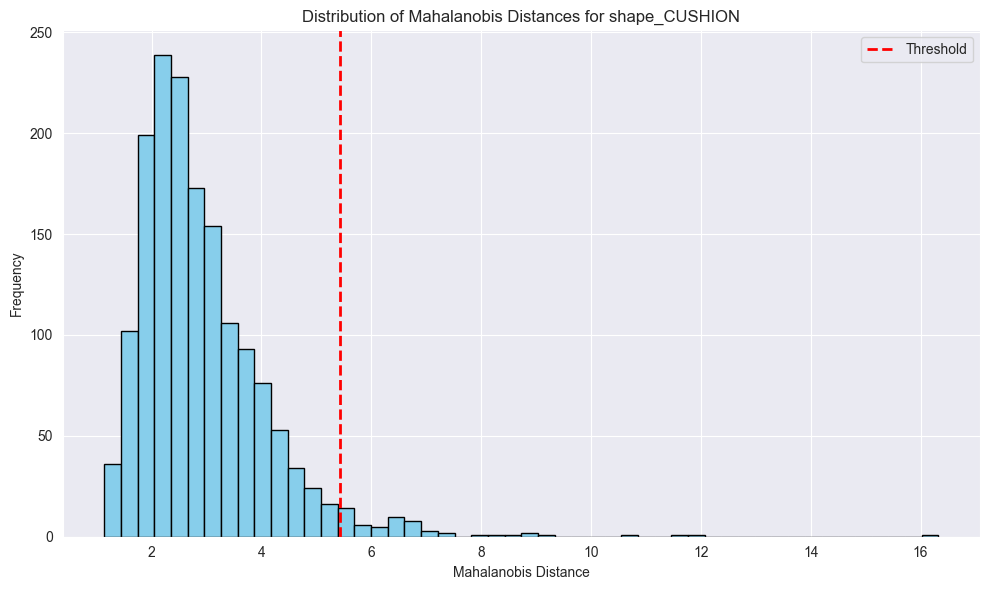

Outliers for shape_CUSHION:
                         id    shape  weight clarity  color cut polish  \
3227             200538-94  CUSHION    1.00      I1    W-X  EX     VG   
3281               1664763  CUSHION    0.56     SI2  FANCY  EX     GD   
3323               1629722  CUSHION    0.61     SI2    Y-Z  EX     EX   
3329               1651867  CUSHION    0.51     VS2  FANCY  EX     GD   
3382               1762708  CUSHION    0.78     VS1    U-V  EX     EX   
3438               1576905  CUSHION    0.60     VS2  FANCY  GD     VG   
3446               1605429  CUSHION    0.61     VS1  FANCY  EX     GD   
3555               1651861  CUSHION    0.75      I1  FANCY  EX     GD   
3596               1672859  CUSHION    0.52     VS2    U-V  EX     EX   
3638               1651860  CUSHION    0.80    VVS1  FANCY  EX     EX   
3915             200705-30  CUSHION    1.10     VS1    U-V  EX     EX   
3935  Eco Diamond LGC10383  CUSHION    1.59     VS1      I  GD     VG   
3936  Eco Diamond LGC1

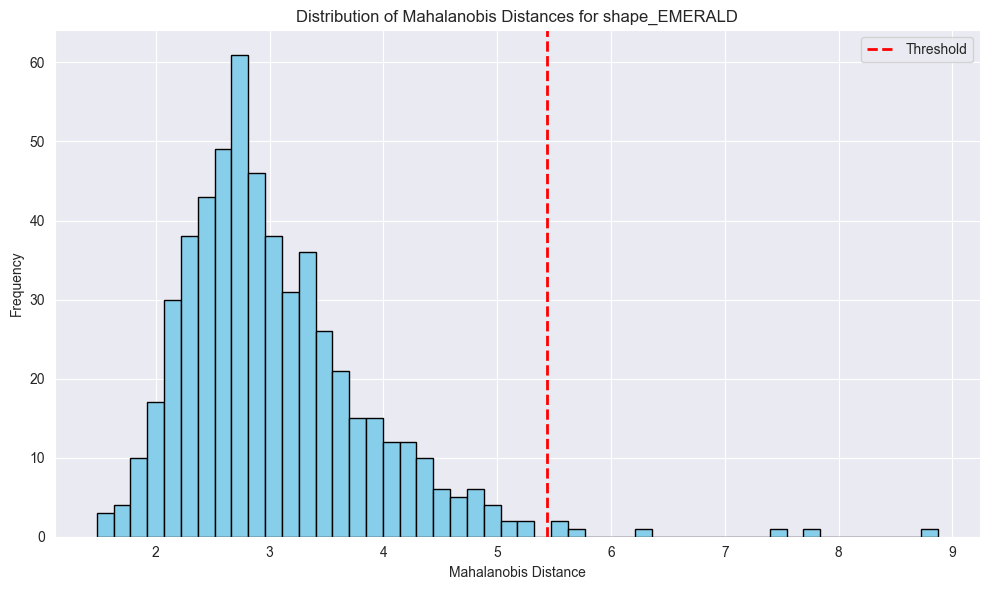

Outliers for shape_EMERALD:
                          id    shape  weight clarity color cut polish  \
927   Eco Diamond 440020244  EMERALD    0.70     SI1     E  EX     EX   
928   Eco Diamond 445027346  EMERALD    0.70     SI1     E  EX     EX   
977                 1672892  EMERALD    0.68     VS1   S-T  EX     EX   
1010  Eco Diamond 440020240  EMERALD    0.71     SI2     D  EX     EX   
1079                1788970  EMERALD    0.52      IF     K  VG     VG   
1100                1781265  EMERALD    0.61     SI1     D  EX     EX   
1105                1799663  EMERALD    0.50    VVS2     E  GD     EX   

     symmetry fluorescence    price  ...  shape_PEAR  shape_PRINCESS  \
927        EX            N  1279.40  ...           0               0   
928        EX            N  1279.40  ...           0               0   
977        VG            N  1153.52  ...           0               0   
1010       EX            N  1188.14  ...           0               0   
1079       VG            M

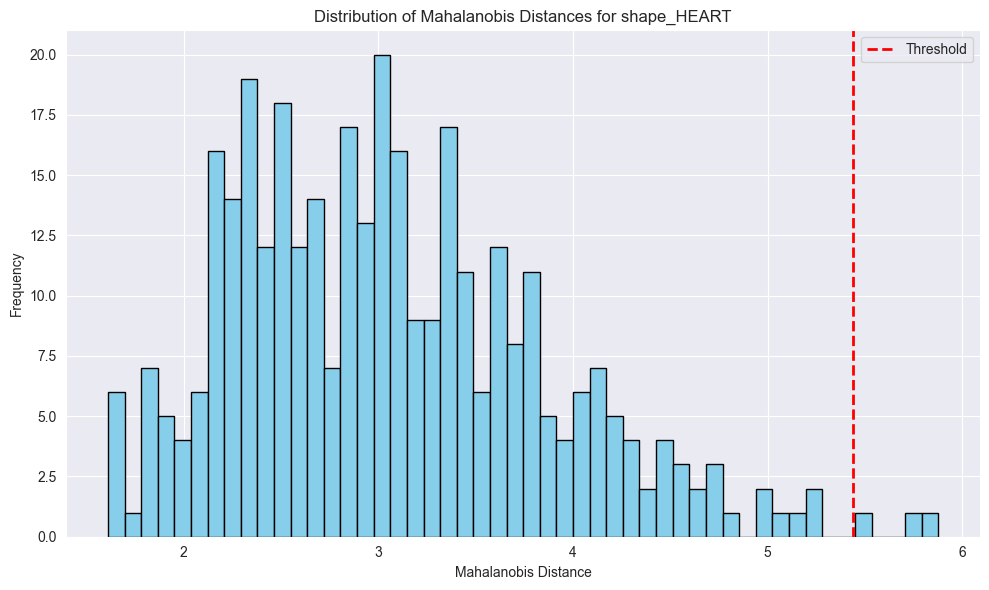

Outliers for shape_HEART:
            id  shape  weight clarity color cut polish symmetry fluorescence  \
4966  1800050  HEART     0.3     SI1     H  VG     VG       FR            F   
5006  1756444  HEART     0.5     VS1     K  VG     VG       VG            N   
5189  1651236  HEART     0.5     SI1     K  VG     GD       VG            N   

        price  ...  shape_PEAR  shape_PRINCESS  shape_ROUND  encoded_clarity  \
4966   881.03  ...           0               0            0              6.0   
5006  1122.21  ...           0               0            0              4.0   
5189  1062.49  ...           0               0            0              6.0   

      encoded_color  encoded_cut  encoded_polish  encoded_symmetry  \
4966            5.0          1.0             1.0               3.0   
5006            8.0          1.0             1.0               1.0   
5189            8.0          1.0             2.0               1.0   

      encoded_fluorescence  is_outlier  
4966         

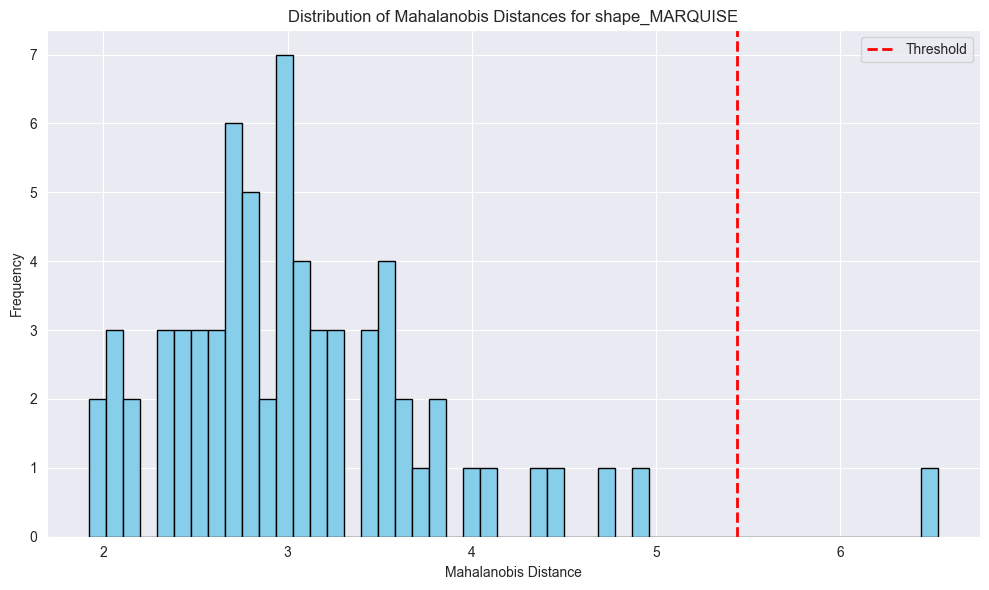

Outliers for shape_MARQUISE:
               id     shape  weight clarity color cut polish symmetry  \
4806  212115-178  MARQUISE     1.0     SI2     M  VG     EX       VG   

     fluorescence    price  ...  shape_PEAR  shape_PRINCESS  shape_ROUND  \
4806            F  1987.62  ...           0               0            0   

      encoded_clarity  encoded_color  encoded_cut  encoded_polish  \
4806              7.0           10.0          1.0             0.0   

      encoded_symmetry  encoded_fluorescence  is_outlier  
4806               1.0                   3.0       False  

[1 rows x 28 columns]

Processing shape: shape_OVAL
Mahalanobis distance threshold at alpha=0.001: 5.440
Number of outliers detected: 19 out of 668 (2.84%)


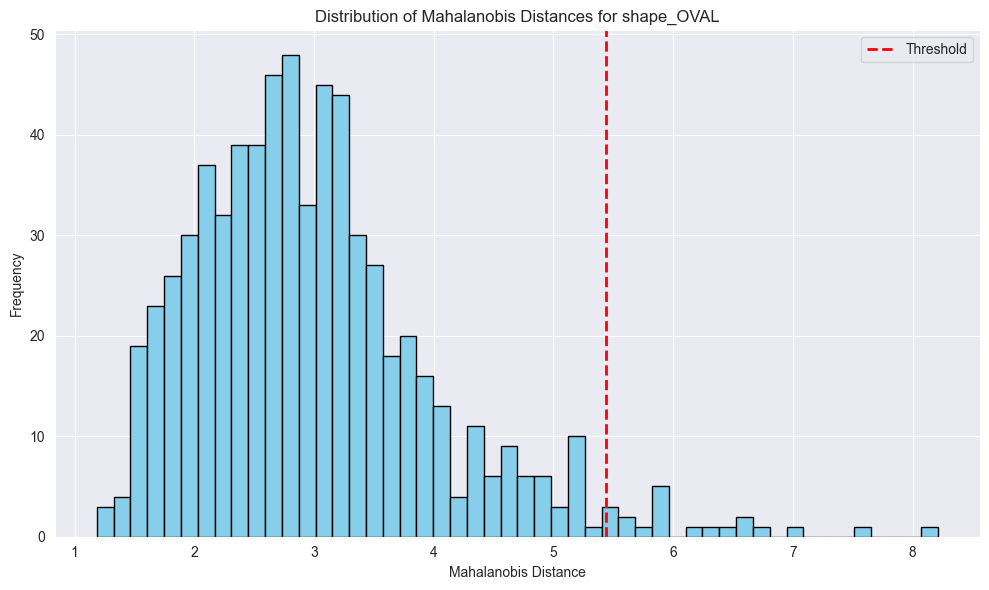

Outliers for shape_OVAL:
                         id shape  weight clarity  color cut polish symmetry  \
5231               1790108  OVAL    0.36      I2  FANCY  EX     VG       FR   
5232               1790102  OVAL    0.30    VVS2  FANCY  EX     VG       FR   
5239               1793287  OVAL    0.30    VVS2      E  EX     GD       GD   
5257               1789987  OVAL    0.30     VS1      I  VG     GD       GD   
5259               1790103  OVAL    0.35     VS1  FANCY  GD     VG       GD   
5302               1748168  OVAL    0.80     SI1  FANCY  VG     EX       VG   
5306               1800398  OVAL    0.40    VVS2  FANCY  EX     VG       FR   
5317               1656608  OVAL    0.50     VS2      I  GD     VG       VG   
5492  Eco Diamond LG200386  OVAL    0.70    VVS2      E  VG     GD       GD   
5525           203221-1605  OVAL    1.00     SI1  FANCY  EX     EX       GD   
5543              200588-8  OVAL    1.17      I2  FANCY  EX     EX       VG   
5553            200650-752

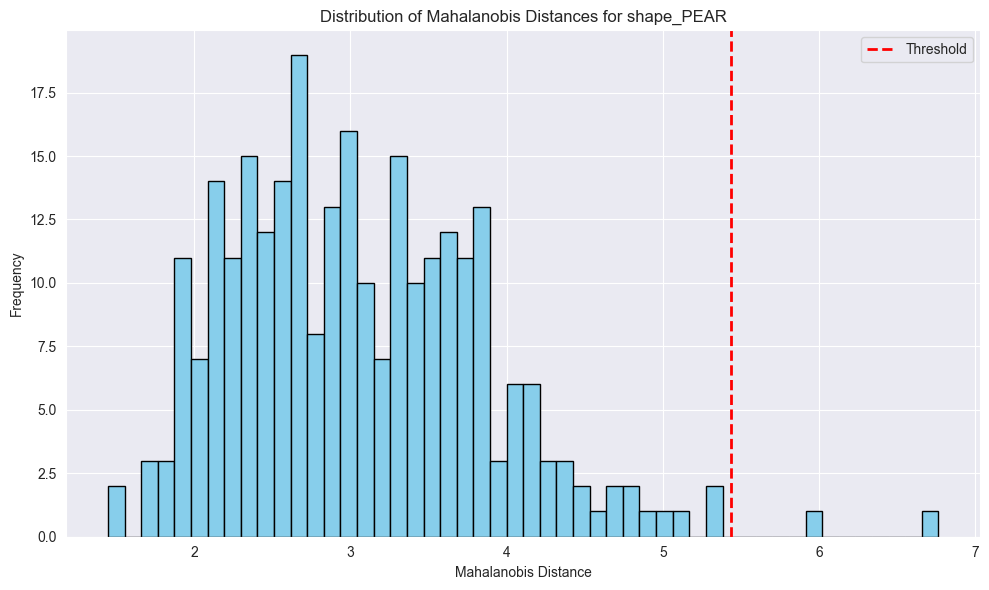

Outliers for shape_PEAR:
              id shape  weight clarity color cut polish symmetry fluorescence  \
3007  210241-20  PEAR    2.22    VVS1     N  VG     EX       EX            M   
3113  210129-37  PEAR    2.29     SI2   U-V  EX     EX       EX            F   

        price  ...  shape_PEAR  shape_PRINCESS  shape_ROUND  encoded_clarity  \
3007  9598.23  ...           1               0            0              2.0   
3113  6560.13  ...           1               0            0              7.0   

      encoded_color  encoded_cut  encoded_polish  encoded_symmetry  \
3007           11.0          1.0             0.0               0.0   
3113           16.0          0.0             0.0               0.0   

      encoded_fluorescence  is_outlier  
3007                   4.0       False  
3113                   3.0       False  

[2 rows x 28 columns]

Processing shape: shape_PRINCESS
Mahalanobis distance threshold at alpha=0.001: 5.440
Number of outliers detected: 12 out of 624 (1.92

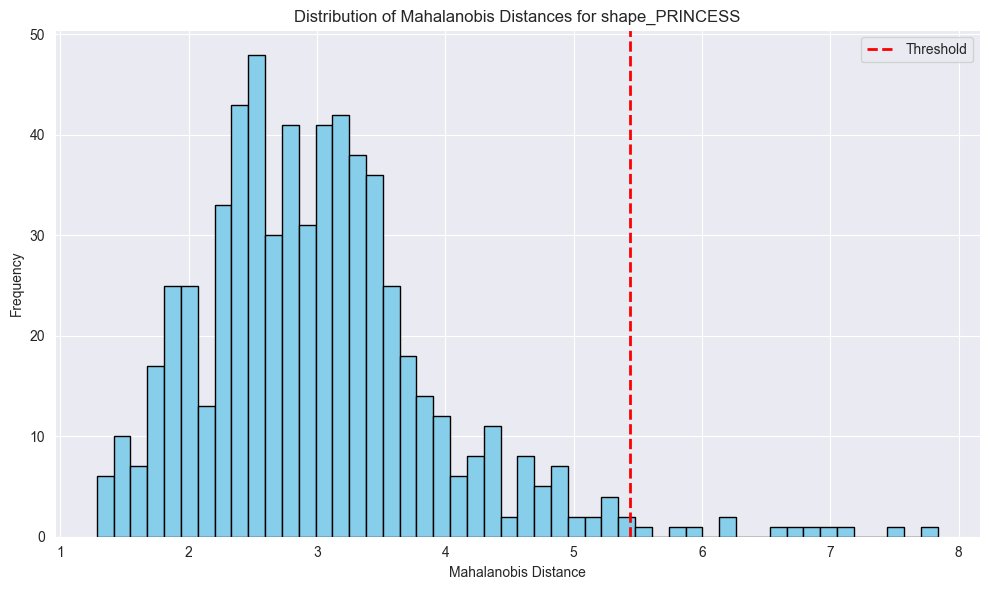

Outliers for shape_PRINCESS:
               id     shape  weight clarity color cut polish symmetry  \
56       1774637  PRINCESS    0.50     VS2     K  GD     EX       GD   
102      1784081  PRINCESS    0.36     VS1     I  EX     VG       GD   
122      1772721  PRINCESS    0.30     VS1     G  VG     VG       GD   
129      1771769  PRINCESS    0.32     VS1     H  EX     GD       FR   
130      1610219  PRINCESS    0.50     VS2   S-T  EX     VG       VG   
386   202228-353  PRINCESS    1.00     SI1   U-V  VG     EX       GD   
453      1660616  PRINCESS    0.92     VS1     N  GD     EX       VG   
455      1669821  PRINCESS    0.70     SI2     F  VG     VG       FR   
456    210019-31  PRINCESS    1.01      I1     L  EX     EX       VG   
461   200787-577  PRINCESS    1.01     SI2     M  EX     VG       VG   
535  203221-1246  PRINCESS    0.96     SI1   U-V  VG     EX       VG   
562   200787-409  PRINCESS    1.01      I1     L  EX     EX       EX   

    fluorescence    price  ...  s

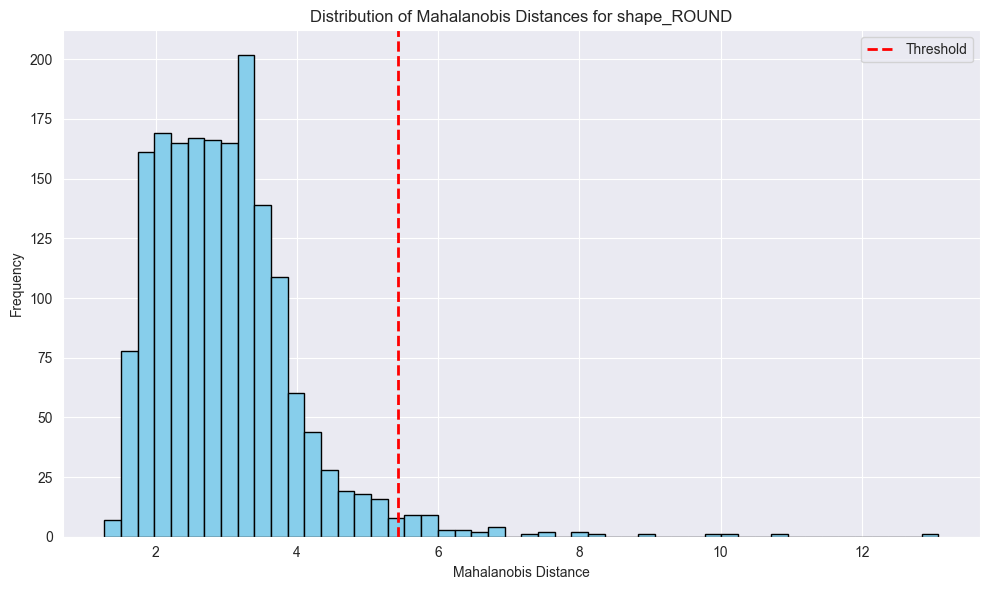

Outliers for shape_ROUND:
                         id  shape  weight clarity  color cut polish symmetry  \
1223               1759230  ROUND    0.36     SI2      D  VG     GD       GD   
1234               1758157  ROUND    0.30     SI1      J  VG     GD       GD   
1236               1618306  ROUND    0.50     SI2      M  GD     EX       EX   
1240               1728145  ROUND    0.18      IF      E  EX     EX       EX   
1241               1655281  ROUND    0.18      IF      E  EX     EX       EX   
1242               1627002  ROUND    0.18      IF      E  EX     EX       EX   
1393               1667677  ROUND    0.50    VVS2      L  VG     GD       VG   
1501               1792852  ROUND    0.50     SI2      J  GD     VG       GD   
1512               1775701  ROUND    0.80     VS2    U-V  VG     VG       VG   
1583               1723330  ROUND    0.71     SI1      K  GD     GD       FR   
1607               1666886  ROUND    0.50     SI2      I  GD      F       GD   
1655         

In [135]:
# 1. Load Your Dataset
df = pd.read_csv('data/processed_data/diamond_features.csv')

# Define all shape features
shape_features = [
    'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
    'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR',
    'shape_PRINCESS', 'shape_ROUND'
]

# Features to be used for analysis (excluding 'price')
features = [
    'weight', 'length', 'width', 'depth', 'encoded_clarity',
    'encoded_color', 'encoded_cut', 'encoded_polish',
    'encoded_symmetry', 'encoded_fluorescence'
]

# 1. Initialize 'is_outlier' column in the main DataFrame
df['is_outlier'] = False

# Initialize a dictionary to store outlier information for each shape
outlier_summary = {}

# Loop through each shape feature
for shape in shape_features:
    print(f"\nProcessing shape: {shape}")

    # 2. Filter the DataFrame for the current shape
    df_shape = df[df[shape] == 1]
    
    if df_shape.empty:
        print(f"No data available for shape: {shape}. Skipping...")
        continue
    
    # 3. Select Features
    X = df_shape[features]
    
    # 4. Standardize the Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 5. Fit the Empirical Covariance Model
    cov = EmpiricalCovariance().fit(X_scaled)
    
    # 6. Compute Mahalanobis Distances
    mahalanobis_distances = cov.mahalanobis(X_scaled)
    
    # Since `cov.mahalanobis` returns squared distances, take the square root
    mahalanobis_distances = np.sqrt(mahalanobis_distances)
    
    # 7. Determine the Threshold
    alpha = 0.001  # Significance level
    df_degrees = X_scaled.shape[1]  # Degrees of freedom equals number of features
    threshold = np.sqrt(chi2.ppf(1 - alpha, df_degrees))
    
    print(f"Mahalanobis distance threshold at alpha={alpha}: {threshold:.3f}")
    
    # 8. Identify Outliers
    is_outlier_shape = mahalanobis_distances > threshold
    
    # 9. Assign the 'is_outlier' flag to the main DataFrame
    df.loc[df[shape] == 1, 'is_outlier'] = is_outlier_shape
    
    # 10. Summary
    num_outliers = is_outlier_shape.sum()
    total = df_shape.shape[0]
    print(f"Number of outliers detected: {num_outliers} out of {total} ({(num_outliers/total)*100:.2f}%)")
    
    # Store the summary
    outlier_summary[shape] = {
        'total': total,
        'outliers': num_outliers
    }
    
    # 11. Visualize the Distances
    plt.figure(figsize=(10, 6))
    plt.hist(mahalanobis_distances, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    plt.title(f'Distribution of Mahalanobis Distances for {shape}')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 12. Inspect Outliers
    outliers_df = df_shape[is_outlier_shape]
    print(f"Outliers for {shape}:\n", outliers_df)

# 13. Overall Summary
print("\nOverall Outlier Summary:")
for shape, summary in outlier_summary.items():
    print(f"{shape}: {summary['outliers']} outliers out of {summary['total']} samples "
          f"({(summary['outliers']/summary['total'])*100:.2f}%)")

# 14. Output the Entire DataFrame with 'is_outlier' Column
output_file = 'data/processed_data/diamond_features_with_outliers.csv'
df.to_csv(output_file, index=False)
print(f"\nThe updated DataFrame with 'is_outlier' column has been saved to '{output_file}'.")



=== Before Dataset Metrics ===
Mean Absolute Error (MAE): 192.0322 ± 14.8783
Mean Squared Error (MSE): 272530.3105 ± 56992.6544
Root Mean Squared Error (RMSE): 518.8706 ± 57.4770
R² Score: 0.8773 ± 0.0181

=== After Dataset Metrics ===
Mean Absolute Error (MAE): 173.3774 ± 1.4674
Mean Squared Error (MSE): 200314.3067 ± 29124.5795
Root Mean Squared Error (RMSE): 446.3828 ± 32.5064
R² Score: 0.9029 ± 0.0120


/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)


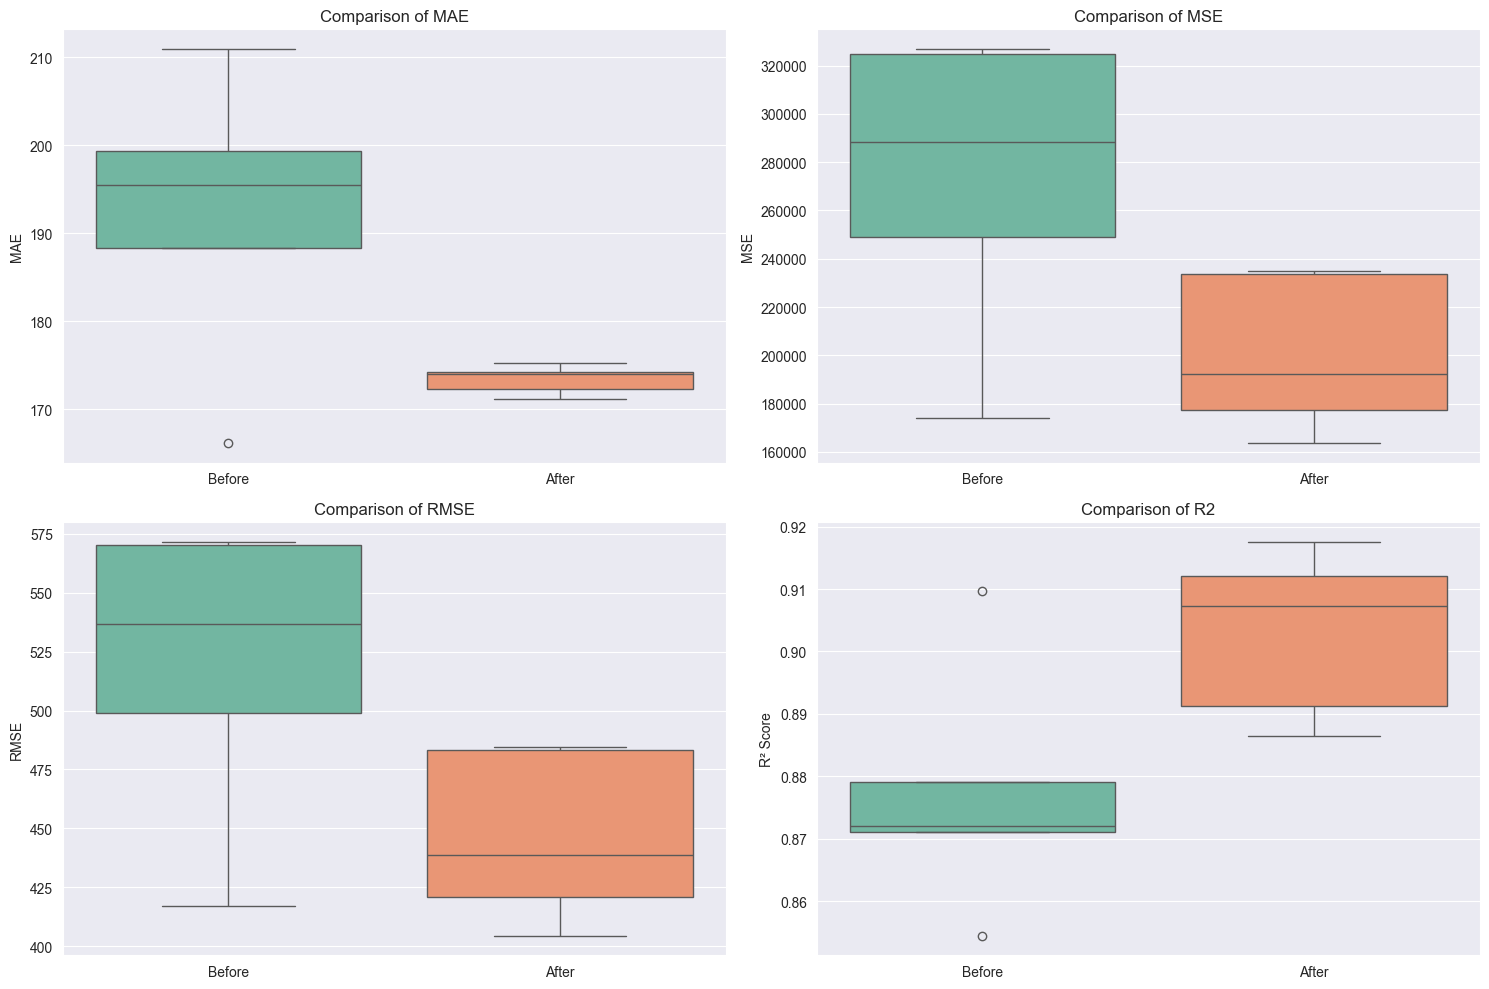

In [136]:
df_with_ol = pd.read_csv('data/processed_data/diamond_features_with_outliers.csv')
df_without_ol = df_with_ol[df_with_ol['is_outlier'] == False]

# Define all shape features
shape_features = [

]

# Features to be used for analysis (excluding 'price')
features = [
    'weight', 'length', 'width', 'depth', 'shape_CUSHION', 'shape_EMERALD', 'shape_HEART',
    'shape_MARQUISE', 'shape_OVAL', 'shape_PEAR', 'shape_PRINCESS', 'shape_ROUND', 'encoded_clarity',
    'encoded_color', 'encoded_cut', 'encoded_polish', 'encoded_symmetry', 'encoded_fluorescence'
]

cross_validate_datasets_with_xgboost_regression(df_with_ol, df_without_ol, relevant_columns_before=features, relevant_columns_after=features)

#### 2.2 Handling outliers and transforming the target feature

I tried to detect outliers in the target feature, but no matter which method I used (IQR is more suitable for skewed data, but I also tried z-score) the number of "outliers" and their characteristics led me to the conclusion that the boundaries for outliers flag data points that are actually part of the natural skew of the distribution, not actual anomalies. So I decided to keep those, and not throw away what I consider relevant data. You can try and see for yourself using the handle_outliers_function.

In [137]:
df_with_ol = pd.read_csv('data/processed_data/diamond_features_with_outliers.csv')
df_without_ol = df_with_ol[df_with_ol['is_outlier'] == False]
handle_outliers(df_without_ol, ['price'], clamp=False)

The shape before handling outliers is: (5740, 28)
Removed 466 outliers from 'price' using IQR method.
The shape after handling outliers is: (5274, 28)


,id,shape,weight,clarity,color,cut,polish,symmetry,fluorescence,price,...,shape_PEAR,shape_PRINCESS,shape_ROUND,encoded_clarity,encoded_color,encoded_cut,encoded_polish,encoded_symmetry,encoded_fluorescence,is_outlier
0,1783153,PRINCESS,0.33,VVS2,E,EX,EX,GD,F,1010.59,...,0,1,0,3.0,2.0,0.0,0.0,2.0,3.0,False
1,1765234,PRINCESS,0.34,VS1,F,EX,EX,VG,N,1010.91,...,0,1,0,4.0,3.0,0.0,0.0,1.0,0.0,False
2,1775625,PRINCESS,0.33,VS1,D,EX,VG,GD,N,1012.26,...,0,1,0,4.0,1.0,0.0,1.0,2.0,0.0,False
3,1649332,PRINCESS,0.50,SI2,K,EX,EX,GD,N,1012.33,...,0,1,0,7.0,8.0,0.0,0.0,2.0,0.0,False
4,1786744,PRINCESS,0.43,VS2,J,EX,EX,GD,N,1012.43,...,0,1,0,5.0,7.0,0.0,0.0,2.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,1672925,OVAL,0.70,SI2,F,EX,EX,VG,F,2240.16,...,0,0,0,7.0,3.0,0.0,0.0,1.0,3.0,False
5874,1766992,OVAL,0.90,SI1,L,EX,EX,VG,F,2240.77,...,0,0,0,6.0,9.0,0.0,0.0,1.0,3.0,False
5876,1664766,OVAL,0.81,VS2,FANCY,EX,EX,VG,M,2242.06,...,0,0,0,5.0,0.0,0.0,0.0,1.0,4.0,False
5877,1668337,OVAL,0.72,SI1,J,EX,EX,EX,N,2243.22,...,0,0,0,6.0,7.0,0.0,0.0,0.0,0.0,False


Next, I tried to use various transformations (log, box-cox and sqrt) on the target feature, but for each such transformation, although the transformed values  reduced the skewness, unfortunately, I got degraded performance (again, you can try for yourself) on the 5-fold cross-validation test, across the metrics MAE, MSE, RMSE and R². So I passed on that. This fits our initial assumption that because XGBoost uses decision trees that are inherently pretty robust to the scale and distribution of the input features, so transformations like log or box-cox often don't make a significant difference. In addition, as we see in our example, sometimes when we transform the target feature, for example by applying log, small prediction errors in the transformed space can be amplified when we invert the transformation for the original scale, leading to degraded performance.

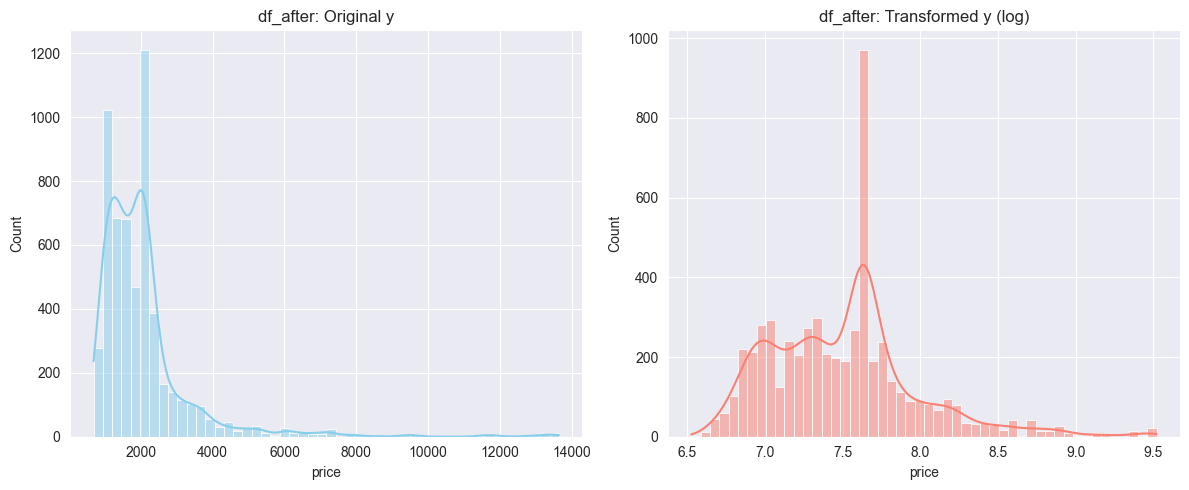

df_after skewness (original):    3.99
df_after skewness (transformed): 0.95

=== Before Dataset Metrics ===
Mean Absolute Error (MAE): 173.3774 ± 1.4674
Mean Squared Error (MSE): 200314.3067 ± 29124.5795
Root Mean Squared Error (RMSE): 446.3828 ± 32.5064
R² Score: 0.9029 ± 0.0120

=== After Dataset Metrics ===
Mean Absolute Error (MAE): 175.0853 ± 8.8364
Mean Squared Error (MSE): 219747.7045 ± 36679.3881
Root Mean Squared Error (RMSE): 467.0993 ± 39.5716
R² Score: 0.8935 ± 0.0159


/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)


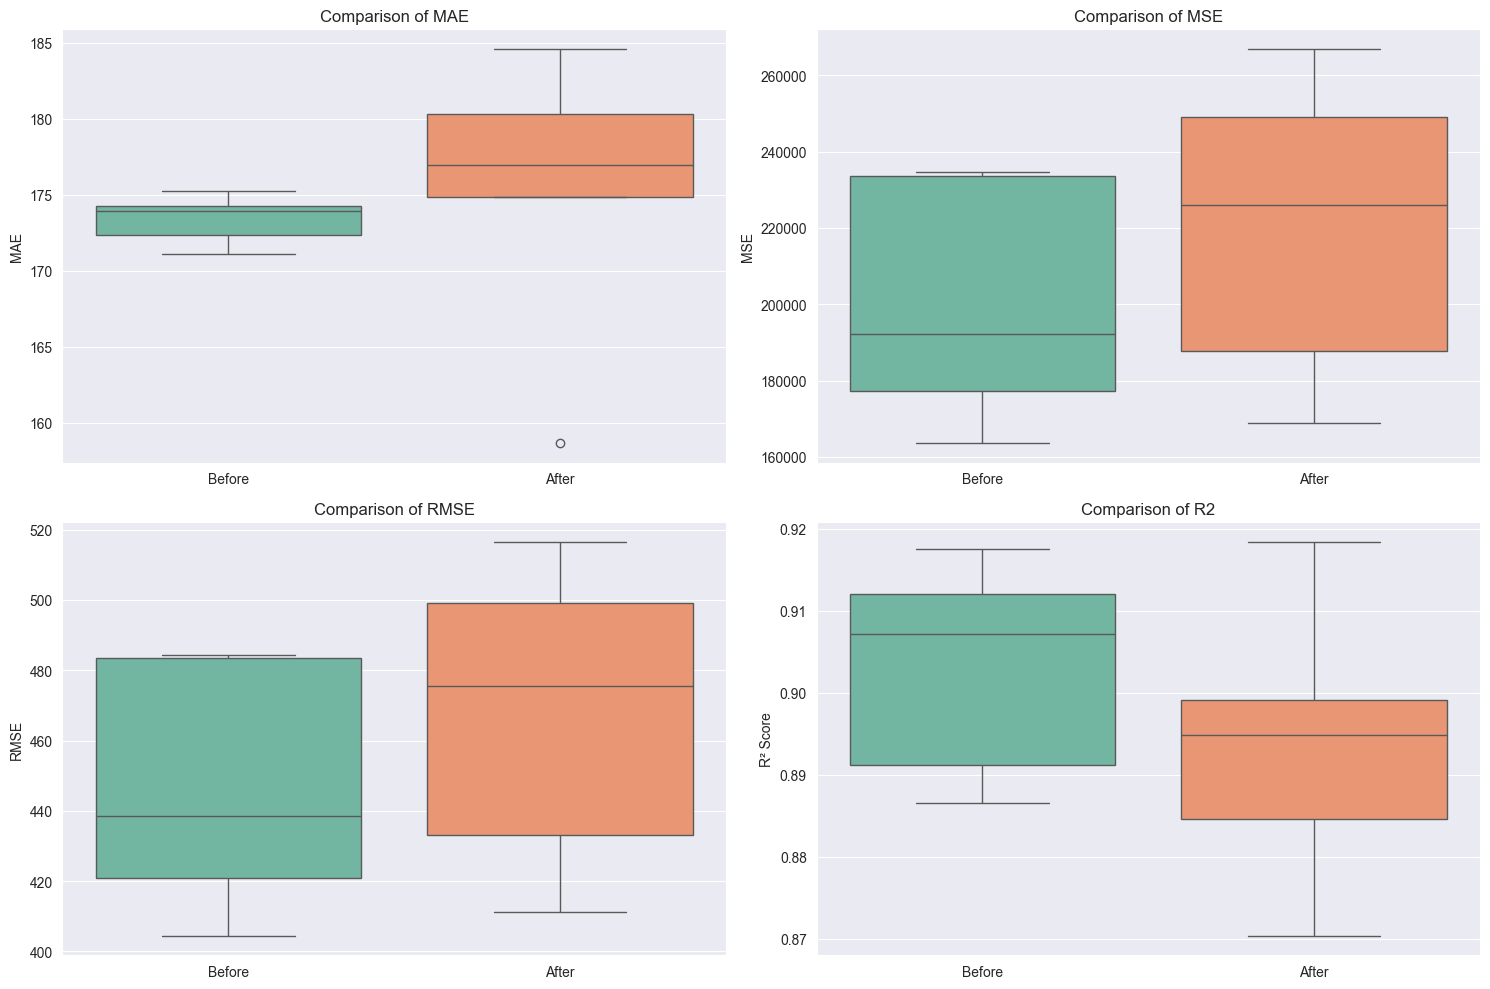

In [142]:
df_with_ol = pd.read_csv('data/processed_data/diamond_features_with_outliers.csv')
df_without_ol = df_with_ol[df_with_ol['is_outlier'] == False]
df_before = df_without_ol.copy()
df_after = df_without_ol.copy()
cross_validate_datasets_with_xgboost_regression(df_before, df_after, relevant_columns_before=predictor_features, relevant_columns_after=predictor_features, target_transform_after='log', visualize_preprocessing_after=True)


#### 2.3 Feature engineering

Next, I tried to come up with new features that will improve the predictive power of the model, applying ratio, multiplications, averaging, transformations and binning of the old features. Unfortunately, although I saw some changes in feature importance, overall performance was degraded when adding the engineered features to the original ones. I assume it occurs due to several reasons:
1. Redundancy and Multicolliniarity - Some engineered features (like volume, avg_dimension, and various ratios) are derived from the same base measurements (length, width, depth, weight). This can create high correlations among features. When features are redundant, the model can have difficulty distinguishing which ones are most relevant, potentially destabilizing training and leading to overfitting.
2. Noise Introduction - If the new features don’t add substantial new information about the target (price), they might just introduce additional noise.
3. Overfitting - With more features, especially ones that are highly interrelated, the model has more degrees of freedom. As a result, the model might start learning the noise in the training data rather than the underlying relationship. This can hurt generalization to new, unseen data.


=== Before Dataset Metrics ===
Mean Absolute Error (MAE): 173.3774 ± 1.4674
Mean Squared Error (MSE): 200314.3067 ± 29124.5795
Root Mean Squared Error (RMSE): 446.3828 ± 32.5064
R² Score: 0.9029 ± 0.0120

=== After Dataset Metrics ===
Mean Absolute Error (MAE): 182.4029 ± 2.7039
Mean Squared Error (MSE): 213501.4283 ± 23983.9144
Root Mean Squared Error (RMSE): 461.3216 ± 26.1495
R² Score: 0.8965 ± 0.0090


/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4097983929.py:800: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)


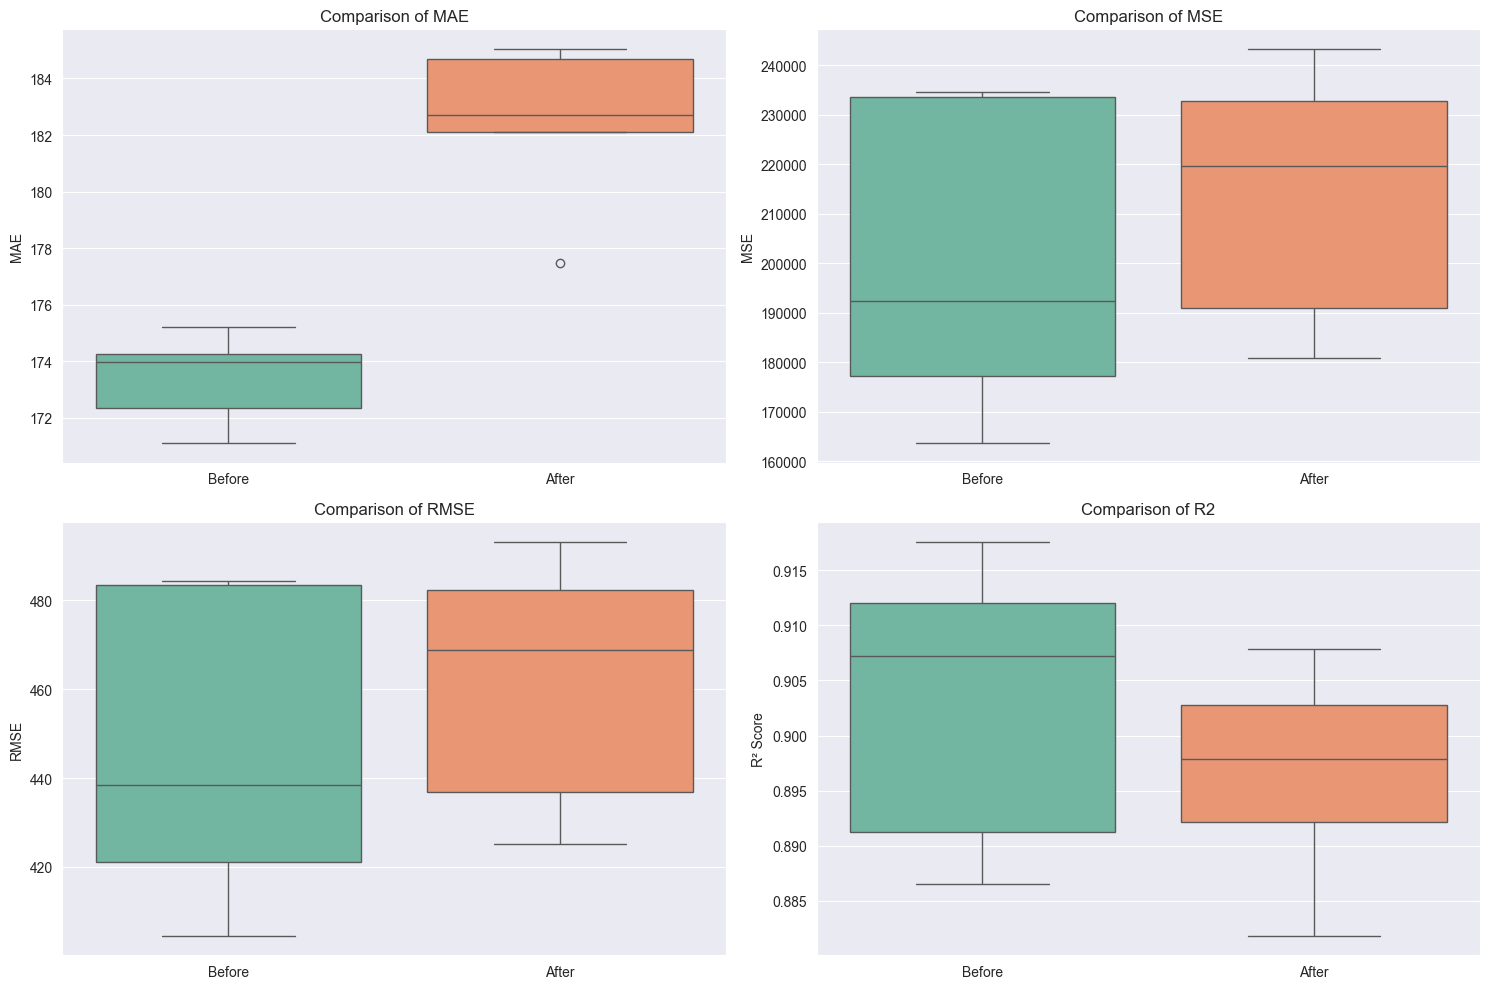

In [146]:
df = pd.read_csv('data/processed_data/diamond_features_with_outliers.csv')
df = df[df['is_outlier'] == False]

# 1. Create new (domain-driven) features

# a. Volume: length * width * depth
df['volume'] = df['length'] * df['width'] * df['depth']

# b. Average dimension (useful for ratio calculations)
df['avg_dimension'] = (df['length'] + df['width']) / 2

# c. Depth ratio: depth / ((length + width) / 2)
df['depth_ratio'] = df['depth'] / df['avg_dimension']

# d. Weight-to-volume ratio: weight / volume
df['weight_volume_ratio'] = df['weight'] / df['volume'].replace({0: np.nan})

# e. Length-to-width ratio
df['length_width_ratio'] = df['length'] / df['width'].replace({0: np.nan})

# f. Combined cut quality (average of cut, polish, symmetry)
df['cut_quality'] = (
    df['encoded_cut'] + df['encoded_polish'] + df['encoded_symmetry']
) / 3.0

# g. Carat threshold indicators (for 1.0, 2.0)
df['carat_bin_1'] = (df['weight'] >= 0.5).astype(int)
df['carat_bin_2'] = (df['weight'] >= 1.0).astype(int)
df['carat_bin_3'] = (df['weight'] >= 1.5).astype(int)
df['carat_bin_4'] = (df['weight'] >= 2.0).astype(int)
df['carat_bin_5'] = (df['weight'] >= 2.5).astype(int)
df['carat_bin_6'] = (df['weight'] >= 3.0).astype(int)
# We could add more thresholds (e.g., 0.5, 1.5, 3.0, etc.)

# h. “Fancy vs. Round” — if shape_ROUND is 1 => Round, else => Fancy
df['is_fancy'] = (df['shape_ROUND'] == 0).astype(int)

# i. Log of carat (due to our skewed data)
df['log_carat'] = np.log1p(df['weight'])


# 2. Incorporate these into your "extended" feature set

existing_features = [
    'weight',
    'price',
    'length',
    'width',
    'depth',
    'shape_CUSHION',
    'shape_EMERALD',
    'shape_HEART',
    'shape_MARQUISE',
    'shape_OVAL',
    'shape_PEAR',
    'shape_PRINCESS',
    'shape_ROUND',
    'encoded_clarity',
    'encoded_color',
    'encoded_cut',
    'encoded_polish',
    'encoded_symmetry',
    'encoded_fluorescence'
]

new_features = [
    'volume',
    'avg_dimension',
    'depth_ratio',
    'weight_volume_ratio',
    'length_width_ratio',
    'cut_quality',
    'carat_bin_1',
    'carat_bin_2',
    'carat_bin_3',
    'carat_bin_4',
    'carat_bin_5',
    'carat_bin_6',
    'is_fancy',
    'log_carat'
]

# Combine them all
extended_features = existing_features + new_features

# 3. Build two different datasets

# baseline dataset
df_before = df[existing_features]

# extended dataset
df_after = df[extended_features]

# 4. Test

cross_validate_datasets_with_xgboost_regression(df_before, df_after, relevant_columns_before=existing_features.remove('price'), relevant_columns_after=extended_features.remove('price'))

#### 2.4 Sampling

Next, I went on and tried to use SMOGN oversampling to balance the dataset. This method does that by generating synthetic data points for underrepresented target values, then adding some variance to the feature to make iit harder for the model to overfit. It then snaps categorical features back to their allowed values. Finally, I compared the performance of the regression models trained on the original versus the oversampled data. It is important to note that this stage marks the first enhancement attempt that I don't want to apply on my entire dataset (I don't want to predict on synthesized samples), that's why I'll create a train, validation and test set split. It is also worth noting that I considered dataset fusion (the process of merging one dataset to another) but I faced issues I was not aware of when first picking this dataset and that require domain expertise: one very important factor that decides a diamond price is the lab evaluating it (usually AGI or EGL but there are others), I don't have information on which lab performed which evaluation (I assume all were done by the same lab), in addition, diamond prices change with time. these two factors made this option more likely to introduce noise than signal, so after examining it - I passed.

##### 2.4.1 Create a train, validation, test split

In [158]:
# Load the dataset and filter out outliers.
df = pd.read_csv('data/processed_data/diamond_features_with_outliers.csv')
df = df[df['is_outlier'] == False]

# First split: 60% training and 40% temporary (to be split into validation and test sets).
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,         # 40% of data goes to temp_df
    random_state=42,
    stratify=df['shape']
)

# Second split: split the temporary set equally into validation (20%) and test (20%) sets.
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,         # 50% of temp_df (i.e., 0.5 * 40% = 20% of original data)
    random_state=42,
    stratify=temp_df['shape']
)

# Print shape distributions in each set.
print("Training set shape distribution:")
print(train_df['shape'].value_counts())
print("\nValidation set shape distribution:")
print(validation_df['shape'].value_counts())
print("\nTest set shape distribution:")
print(test_df['shape'].value_counts())

# Reset indices to avoid potential indexing issues later.
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save the sets for future reference.
train_df.to_csv('data/processed_data/diamond_features_wo_outliers_train.csv', index=False)
validation_df.to_csv('data/processed_data/diamond_features_wo_outliers_validation.csv', index=False)
test_df.to_csv('data/processed_data/diamond_features_wo_outliers_test.csv', index=False)

print(f"Train set created with {len(train_df)} samples.")
print(f"Validation set created with {len(validation_df)} samples.")
print(f"Test set created with {len(test_df)} samples.")

Training set shape distribution:
ROUND       1031
CUSHION      924
OVAL         390
PRINCESS     367
EMERALD      325
HEART        205
PEAR         162
MARQUISE      40
Name: shape, dtype: int64

Validation set shape distribution:
ROUND       344
CUSHION     308
OVAL        129
PRINCESS    122
EMERALD     109
HEART        69
PEAR         54
MARQUISE     13
Name: shape, dtype: int64

Test set shape distribution:
ROUND       343
CUSHION     308
OVAL        130
PRINCESS    123
EMERALD     108
HEART        68
PEAR         54
MARQUISE     14
Name: shape, dtype: int64
Train set created with 3444 samples.
Validation set created with 1148 samples.
Test set created with 1148 samples.


##### 2.4.2 Over-sample the training set

In [197]:
# Set random seeds for reproducibility.
random.seed(42)
np.random.seed(42)

def snap_to_allowed(val, allowed_values):
    """
    Snap a value to the closest allowed value.
    """
    allowed_values = np.array(allowed_values)
    idx = (np.abs(allowed_values - val)).argmin()
    return allowed_values[idx]

def apply_smogn_with_cat_fix(
    data: pd.DataFrame,
    target: str,
    cat_cols_allowed: dict,
    rel_thres: float = 0.2,
    rel_method: str = 'auto',
    k: int = 18,
    samp_method: str = 'extreme',
) -> pd.DataFrame:
    """
    Applies SMOGN oversampling to the dataset and then post-processes columns that are
    ordered categorical (encoded as floats) to snap them back to allowed values.
    """
    df_smogn = smogn.smoter(
        data=data,
        y=target,
        rel_thres=rel_thres,
        rel_method=rel_method,
        k=k,
        samp_method=samp_method,
    )
    
    for col, allowed_values in cat_cols_allowed.items():
        if col in df_smogn.columns:
            df_smogn[col] = df_smogn[col].apply(lambda x: snap_to_allowed(x, allowed_values))
    
    return df_smogn

# Load the train data.
train_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_train.csv')

# Specify ordered categorical columns and their allowed values.
cat_columns_allowed = {
    'encoded_clarity': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    'encoded_color': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, 16.0, 18.0, 19.0],
    'encoded_cut': [0.0, 1.0, 2.0, 3.0],
    'encoded_polish': [0.0, 1.0, 2.0],
    'encoded_symmetry': [0.0, 1.0, 2.0, 3.0],
    'encoded_fluorescence': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
}

# Apply SMOGN oversampling on the training set only.
oversampled_train_df = apply_smogn_with_cat_fix(
    data=train_df,
    target='price',
    cat_cols_allowed=cat_columns_allowed,
    rel_thres=0.6,
    samp_method='extreme',
)

# Save the oversampled training set for future reference.
oversampled_train_df.to_csv('data/processed_data/diamond_features_wo_outliers_train_oversampled.csv', index=False)

r_index: 100%|##########| 95/95 [00:00<00:00, 497.64it/s]


##### 2.4.3 validate training set vs. over-sampled training set


=== Model Performance on Test Set ===

--- df_before Model ---
MAE:  204.0995
MSE:  339978.6457
RMSE: 583.0769
R²:   0.8459

--- df_after Model ---
MAE:  204.6059
MSE:  313828.1362
RMSE: 560.2037
R²:   0.8578


/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4112064450.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4112064450.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4112064450.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)
/var/folders/fh/6bwh95w11tlctg156bc4csb80000gn/T/ipykernel_34695/4112064450.py:734: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets)


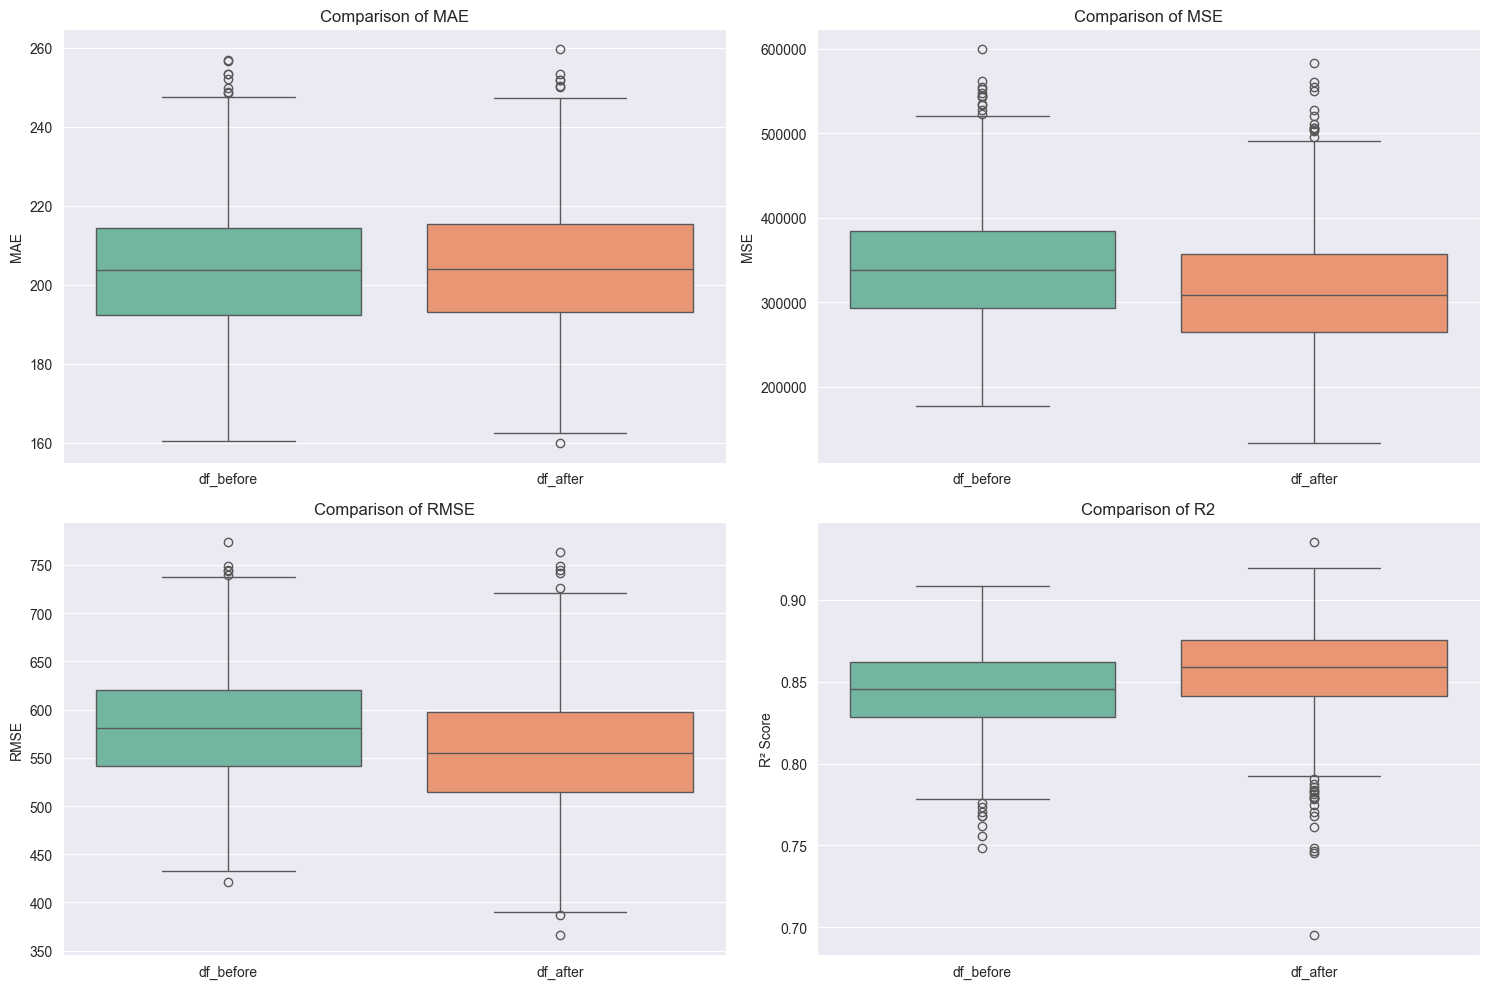

In [198]:
# Load both datasets
train_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_train.csv')
oversampled_train_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_train_oversampled.csv')

# Load the validation set
validation_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_validation.csv')

compare_datasets_with_xgboost_regression(
    df_before=train_df,
    df_after=oversampled_train_df,
    test_df=validation_df,
    target='price',
    relevant_columns_before=predictor_features,
    relevant_columns_after=predictor_features,
    random_state=42,
    visualize=True,
)

#### 2.5 Hyperparameter tuning

Next, I defined a hyperparameter tuning pipeline for training an XGBoost regression model using Optuna. It starts by selecting relevant features from the provided training and validation datasets. The objective function for the Optuna study defines a search space for various hyperparameters like max_depth, min_child_weight, and eta, among others, which are tuned to minimize the root mean squared error (RMSE) using 5-fold cross-validation (over a concatenation of the train and validation sets). After running the optimization process with Optuna, the best hyperparameters are extracted, and a final model is trained on the entire dataset with these optimized parameters. The model is then saved as a pickle file for future use, and the best hyperparameters and their corresponding performance metrics are displayed. Then, I trained a base model for comparison.

###### 2.5.1 Search and save the best model

In [199]:
hyperparameter_tuning_pipeline('data/processed_data/diamond_features_wo_outliers_train.csv', 'data/processed_data/diamond_features_wo_outliers_validation.csv')

[I 2025-02-11 13:15:22,070] A new study created in memory with name: no-name-10c606a6-16b2-44f0-97bf-ef7ce67d3d82
[I 2025-02-11 13:15:26,664] Trial 0 finished with value: 507.7609193006947 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'eta': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 1.1430983876313219, 'alpha': 1.574189004745663, 'n_estimators': 641}. Best is trial 0 with value: 507.7609193006947.
[I 2025-02-11 13:15:29,866] Trial 1 finished with value: 545.1626997699531 and parameters: {'max_depth': 8, 'min_child_weight': 1, 'eta': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'lambda': 1.5254729458052607, 'alpha': 0.0006690421166498799, 'n_estimators': 572}. Best is trial 0 with value: 507.7609193006947.
[I 2025-02-11 13:15:31,077] Trial 2 finished with value: 490.2423517971494 and parameters: {'max_depth': 6,

Best Parameters: {'max_depth': 9, 'min_child_weight': 4, 'eta': 0.01779796845351863, 'subsample': 0.5879039126535096, 'colsample_bytree': 0.9591915791126021, 'gamma': 3.55135549843972, 'lambda': 7.784705607975501, 'alpha': 1.4234497207512265e-05, 'n_estimators': 623}
Best CV RMSE: 472.90432346378157
Final model saved to 'models/best_model.pkl'


(XGBRegressor(alpha=1.4234497207512265e-05, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9591915791126021, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.01779796845351863, eval_metric='rmse', feature_types=None,
              gamma=3.55135549843972, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=7.784705607975501,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=623, ...),
 <optuna.study.study.Study at 0x3197299a0>)

###### 2.5.2 Base model training

In [215]:
train_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_train.csv')
train_df = train_df[all_features]
validation_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_validation.csv')
validation_df = validation_df[all_features]
train_xgb_with_validation_save_model(train_df, validation_df, 'price', 'models/base_model.pkl')

[0]	validation_0-rmse:1179.53680
[1]	validation_0-rmse:972.79627
[2]	validation_0-rmse:809.33368
[3]	validation_0-rmse:731.15747
[4]	validation_0-rmse:682.94041
[5]	validation_0-rmse:649.07604
[6]	validation_0-rmse:631.99812
[7]	validation_0-rmse:616.54860
[8]	validation_0-rmse:602.56910
[9]	validation_0-rmse:592.73853
[10]	validation_0-rmse:600.61666
[11]	validation_0-rmse:594.75134
[12]	validation_0-rmse:597.28855
Validation RMSE: 592.7385
Model saved to models/base_model.pkl


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=3,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### 3. Analyzing the Improved Model

#### 3.1 Feature importance

Next, I'll visualize the importance of features in the enhanced XGBoost model using different methods, such as SHAP values, permutation importance, and XGBoost's built-in feature importance. The code generates plots to display the top n most important features based on the selected method, allowing for easy comparison of feature contributions to model performance. The differences between the different interpretation types are:
- SHAP: Provides a detailed, instance-level explanation of feature importance.
- Permutation: Provides a global measure of feature importance by assessing performance degradation when features are shuffled.
- XGBoost Built-in: Provides model-internal measures of feature importance based on how features are used in splits.
* Weight measures how many times a feature is used in the decision process, but doesn't reflect the effectiveness of those decisions.
* Gain measures the contribution of a feature to improving the model's prediction, providing a clearer picture of its importance in model performance.
* Cover measures how many data samples are influenced by a feature’s splits, highlighting its broader impact on the dataset.
* Total Gain is the cumulative sum of the gain for a feature across all trees, showing the total contribution of the feature to reducing model error.
* Total Cover is the cumulative sum of cover for a feature across all trees, reflecting how many data points are impacted by the feature’s splits.

##### 3.1.1 Enhanced model feature importance

As you can see there's pretty much an agreement across all interpretations that the most important feature is weight, which is pretty much expected. The 3 dimensions that correlate with weight (length, width and depth) are usually also in the top 6 of important features. Some other important features are color which is also expected as this is one of the main characteristics of a diamond, as clarity which is another important feature. It is also worth noting that the shapes pear, heart and oval also carry a strong predictive power as reflected in the Gain chart.

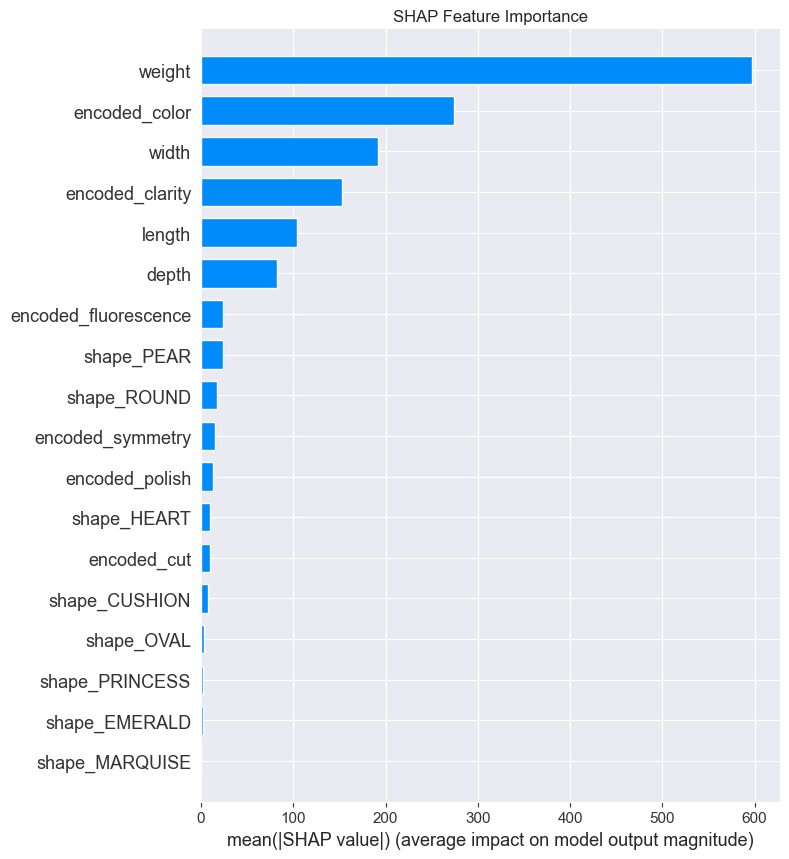

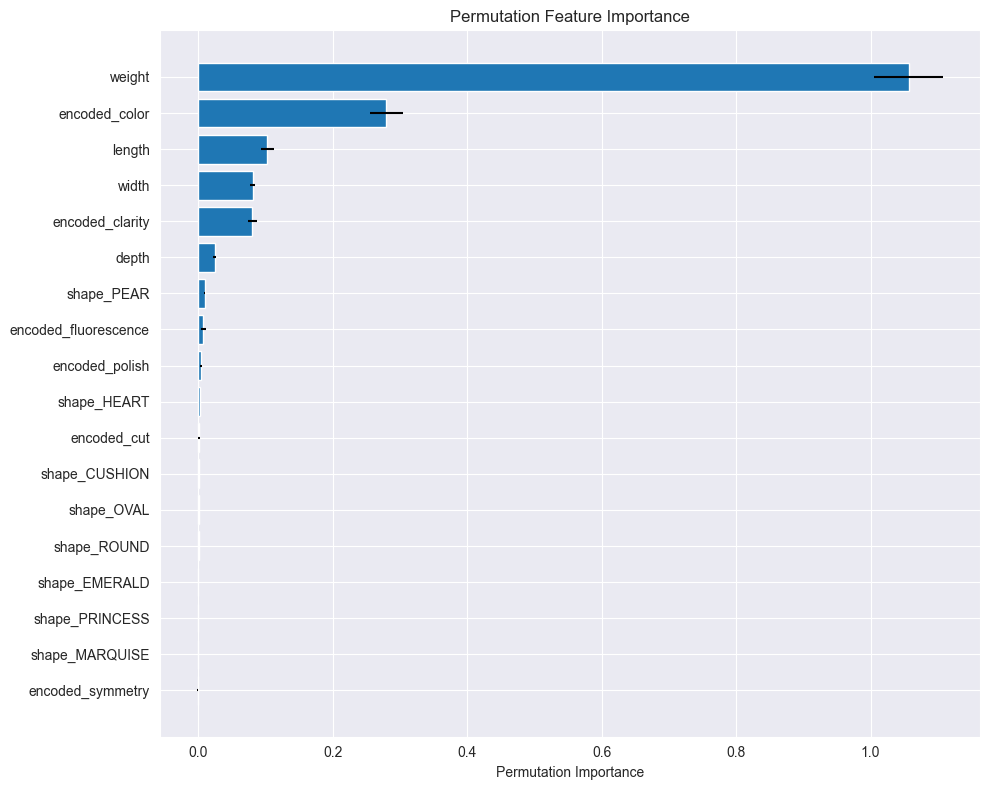

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

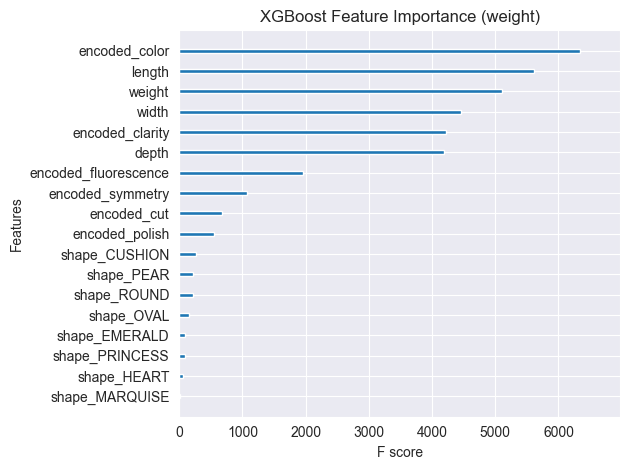

<Figure size 1000x800 with 0 Axes>

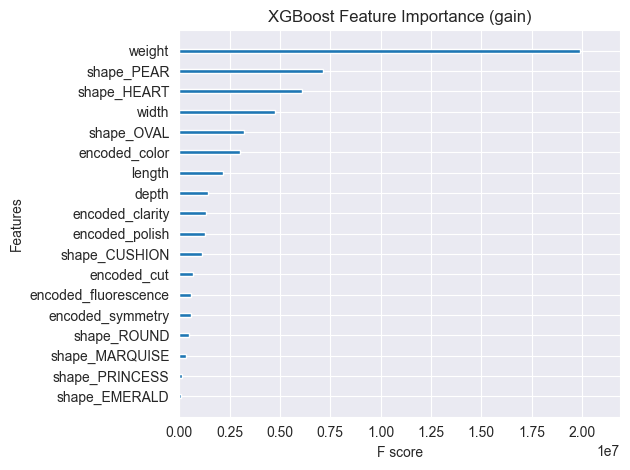

<Figure size 1000x800 with 0 Axes>

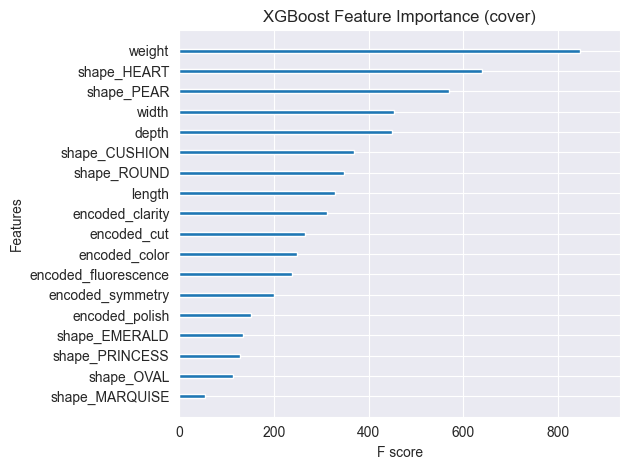

<Figure size 1000x800 with 0 Axes>

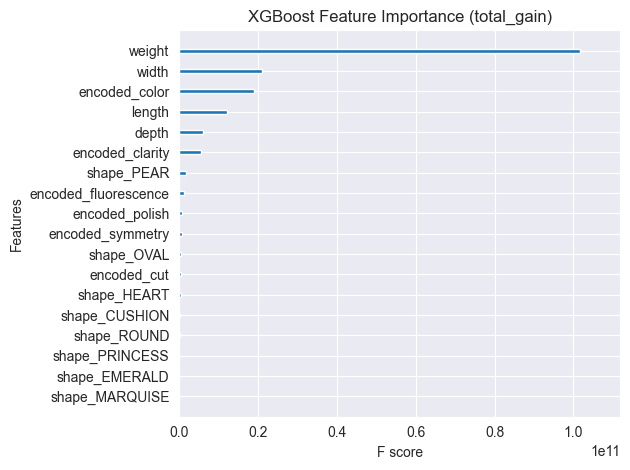

<Figure size 1000x800 with 0 Axes>

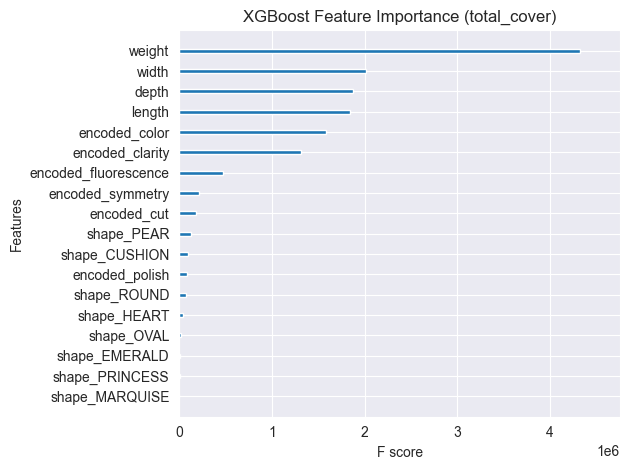

In [222]:
# Load the test dataset
df = pd.read_csv("data/processed_data/diamond_features_wo_outliers_test.csv")
df = df[all_features]

# Split to predictor and target
X = df.drop(columns=["price"])
y = df["price"]

# Load the enhanced XGBoost model
xg_regressor_base = load_xgb_model('models/best_model.pkl')

visualize_feature_importance(xg_regressor_base, X, y, 'shap')
visualize_feature_importance(xg_regressor_base, X, y, 'permutation')
visualize_feature_importance(xg_regressor_base, X, y, 'xgboost')

##### 3.1.2 Base model feature importance (optional view)

I decided to let you the option to view the same interpretations as above for the base model. It shows that a bit less importance assigned to the shapes (somewhat correlative with less common shapes within the dataset). This occurs probably because by oversampling certain examples, we change the effective weights in the dataset. Since XGBoost’s feature importance is calculated based on how much each feature contributes to reducing the error during splits, features that appear more frequently (or have more “weight”) will naturally show higher importance.

In [226]:
# # Load the base XGBoost model
# xg_regressor_base = load_xgb_model('models/base_model.pkl')
# 
# visualize_feature_importance(xg_regressor_base, X, y, 'shap')
# visualize_feature_importance(xg_regressor_base, X, y, 'permutation')
# visualize_feature_importance(xg_regressor_base, X, y, 'xgboost')

#### 3.2 Testing the base model vs. the (enhanced) best model on the test (held-out) set

Performance Explanation:
The enhanced model shows a higher R² score and lower RMSE, meaning it explains more variance and its predictions are closer to the true values. Additionally, the higher Pearson correlation indicates that the relationship between predictions and true outcomes is stronger. These improvements suggest that the modifications (such as oversampling, tuning, and also outlier removal - but that was applied to both models) have led to a model that better captures the underlying patterns in the data.


=== Baseline Model Metrics ===
Mean Absolute Error (MAE): 201.5263
Mean Squared Error (MSE): 219578.0354
Root Mean Squared Error (RMSE): 468.5915
R² Score: 0.8913
Pearson Correlation: 0.9513

=== Improved Model Metrics ===
Mean Absolute Error (MAE): 169.9795
Mean Squared Error (MSE): 151962.3607
Root Mean Squared Error (RMSE): 389.8235
R² Score: 0.9248
Pearson Correlation: 0.9623


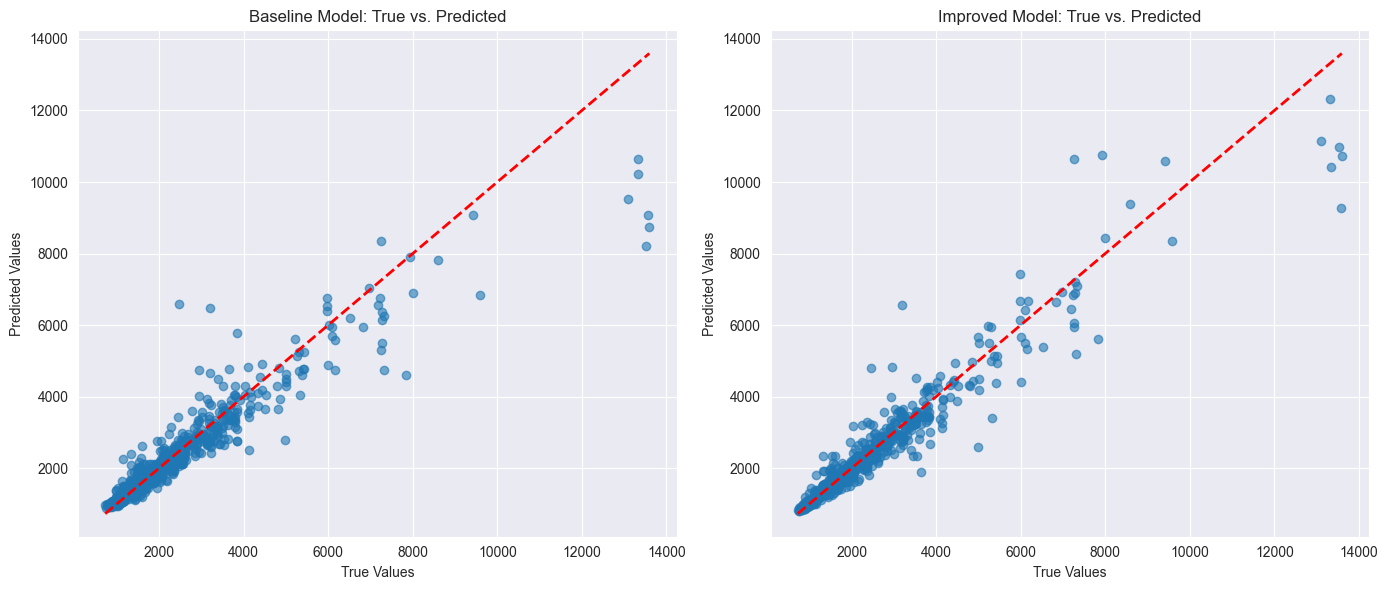

In [236]:
test_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_test.csv')
evaluate_xgboost_models('models/base_model.pkl', 'models/best_model.pkl', test_df, 'price', columns_to_select = predictor_features, visualize=True)

### 4. Drawing Conclusions About the Data & Creative Applications

#### 4.1 Conclusions on the data

- Feature significance: The most influential features are weight and color, In addition, the diamond's dimensions that are very important but also highly correlated with the weight of course. There are also clarity and fluorescence which are pretty significant as well. The dataset we have lacks data samples on various shapes (and also some other features such as cut and polish, but first and foremost shape), that is partially mitigated by the enhancement steps we took, but all in all it would have been better if we had more diversified data to begin with.

- Biases and trends: As we can see in the following graphs (and from the graph above), the improved model still have some bias towards erroneous predictions on the higher prices, but we can also see this has been reduced, probably due to the contribution of oversampling, but not eliminated, because we wanted to be conservative with the amounts of generated synthesized samples we created to augment the dataset and the noise we applied to them to combat overfitting. We can also see that the most correlative features to the absolute errors are the weight and dimension (length, width and depth) features that are correlated (and are also at the top of our important features) and the pear shape which is also correlated with higher prices (and larger diamonds).

=== Model Bias Analysis ===
Mean Residual: -23.6057  --> Model is underestimating on average.
Median Residual: -5.0916
Standard Deviation of Residuals: 389.1081



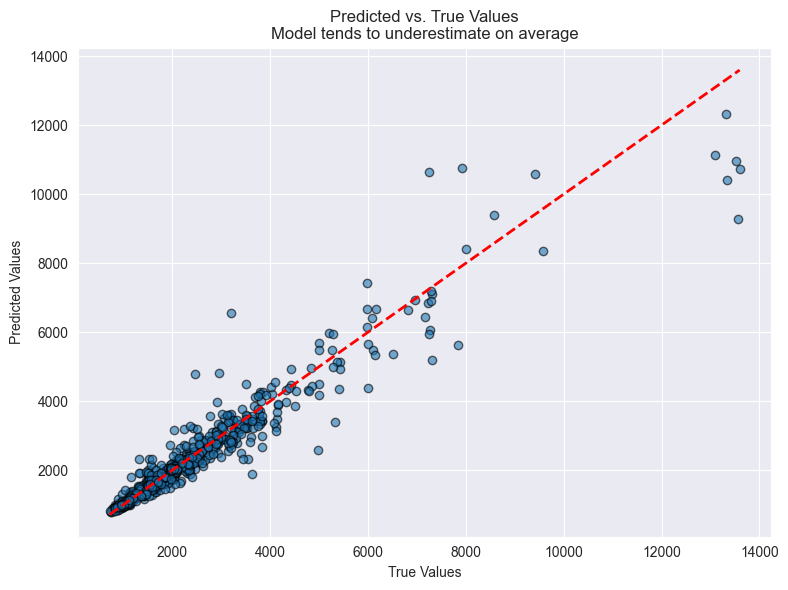

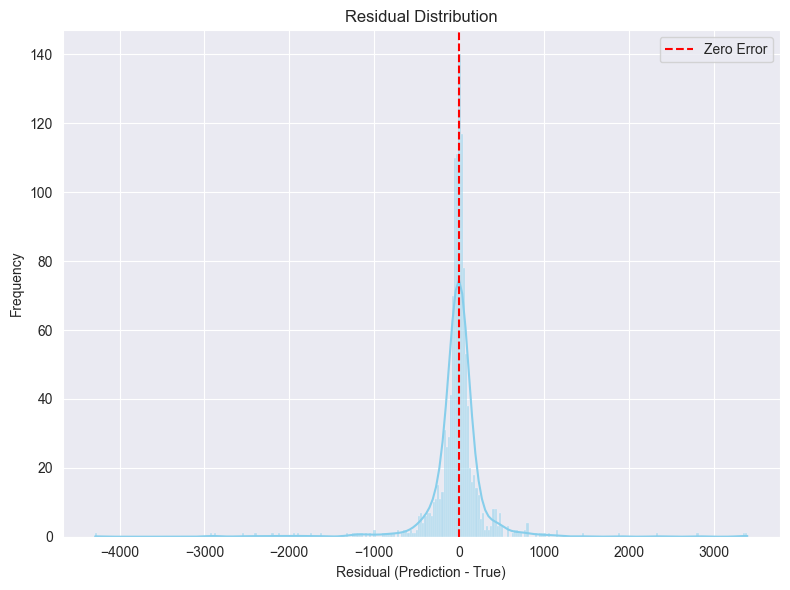

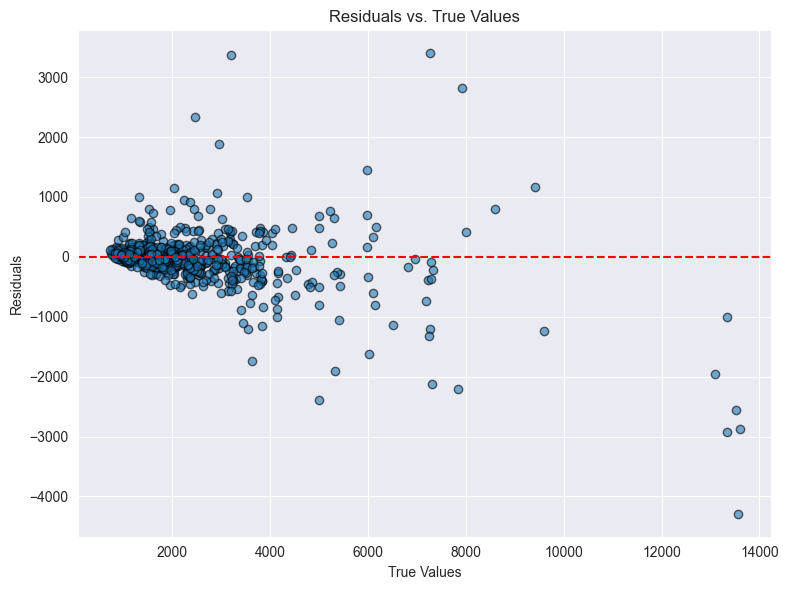

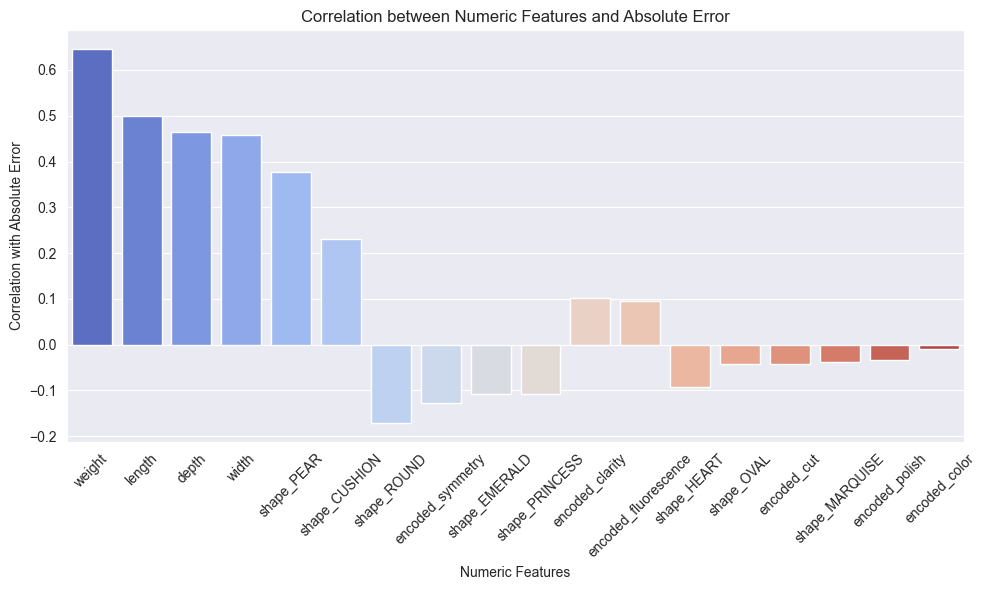

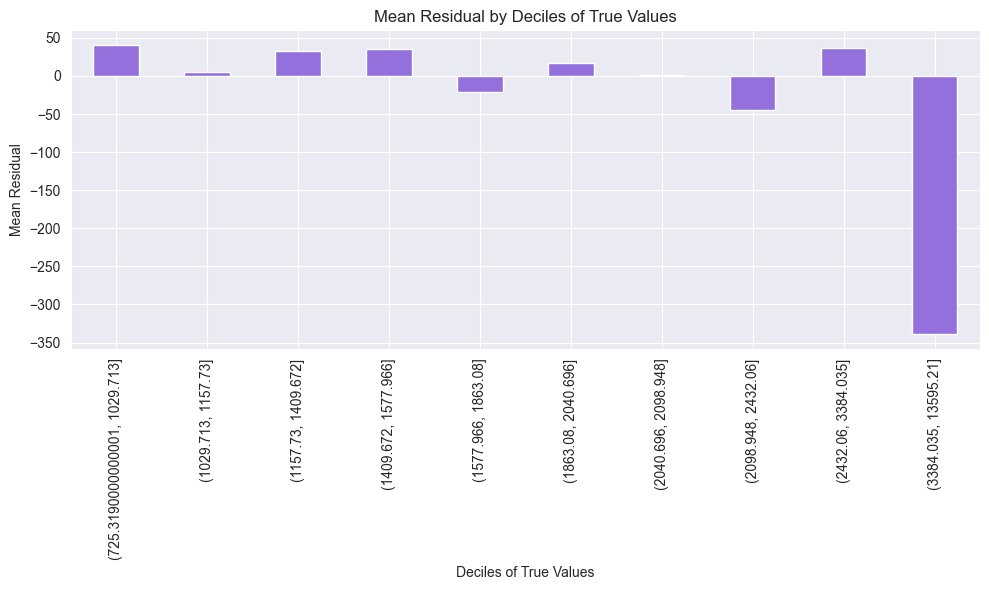

In [242]:
test_df = pd.read_csv('data/processed_data/diamond_features_wo_outliers_test.csv')
test_df = test_df[all_features]
visualize_model_bias_trends('models/best_model.pkl', test_df, 'price')

#### 4.3 potential applications

- Besides the obvious uses this model have to help stakeholders predict diamond prices more accurately (for example and app in which a relevant persona can input diamond feature values and get an estimated price), we can take it a step further and use the pipeline itself on enriched data, then create intersections on these enriched features (for example, buyer's age or geographical location), then we can use the findings to create personalized recommendations for pricing, campaigns etc.
- We can also use feedback on customer purchases in a time series scenario to create a dynamic model that keeps updating. Such a model can help, for example, forecast demands and predict earnings, in addition, it can shed some light on the relative importance of different features when deciding which types of diamonds to stock.